In [122]:
using CSV, DataFrames
using PyPlot, LaTeXStrings, PyCall
@pyimport numpy as np
@pyimport scienceplots

In [123]:
# 船体に働く流体力
function X_H(u, v, r)
    U = sqrt(u^2 + (v - r * x_G)^2)
    β = asin(-(v - r * x_G) / U)
    r_dash = r * L_pp / U
    v_dash = v / U
    return 0.5 * ρ * L_pp * d * U^2 * X_H_dash(v_dash, r_dash)
end

function Y_H(u, v, r)
    U = sqrt(u^2 + (v - r * x_G)^2)
    β = asin(-(v - r * x_G) / U)
    r_dash = r * L_pp / U
    v_dash = v / U
    return 0.5 * ρ * L_pp * d * U^2 * Y_H_dash(v_dash, r_dash)
end

function N_H(u, v, r)
    U = sqrt(u^2 + (v - r * x_G)^2)
    β = asin(-(v - r * x_G) / U)
    r_dash = r * L_pp / U
    v_dash = v / U
    return 0.5 * ρ * L_pp^2 * d * U^2 * N_H_dash(v_dash, r_dash)
end

# 船体に働く流体力(無次元)
function X_H_dash(β, r_dash)
    return -R_0_dash + X_vv_dash*β^2 + X_vr_dash*β*r_dash + X_rr_dash*r_dash^2 + X_vvvv_dash*β^4
end

function Y_H_dash(β, r_dash)
    return Y_v_dash*β + Y_r_dash*r_dash + Y_vvr_dash*β^2*r_dash + Y_vrr_dash*β*r_dash^2 + Y_vvv_dash*β^3 + Y_rrr_dash*r_dash^3
end

function N_H_dash(β, r_dash)
    return N_v_dash*β + N_r_dash*r_dash + N_vvr_dash*β^2*r_dash + N_vrr_dash*β*r_dash^2 + N_vvv_dash*β^3 + N_rrr_dash*r_dash^3
end

# 舵に働く力
function X_R(u, v, r, δ, n_p)
    return -(1 - t_R) * F_N(u, v, r, δ, n_p) * sin(δ)
end

function Y_R(u, v, r, δ, n_p)
    return -(1 + a_H) * F_N(u, v, r, δ, n_p) * cos(δ)
end

function N_R(u, v, r, δ, n_p)
    return -(x_R + a_H * x_H) * F_N(u, v, r, δ, n_p) * cos(δ)
end

function F_N(u, v, r, δ, n_p)
    U = sqrt(u^2 + (v - r * x_G)^2)
    β = asin(-(v - r * x_G) / U)
    r_dash = r * L_pp / U
    w_P = w_P0 * exp(-4.0 * (β - x_P * r_dash)^2)
    u_p = (1 - w_P) * u
    u_R = ϵ * u_p * sqrt(η * (1 + κ * (sqrt(1 + (8 * K_T(u, v, r, n_p)) / (π * J(u, v, r, n_p)^2)) - 1))^2 + (1 - η))
    β_R = β - l_R * r_dash
    if β_R < 0.0
        γ_R = γ_R_minus
    else
        γ_R = γ_R_plus
    end 
    v_R = U * γ_R * (β - l_r_dash * r_dash)
    α_R = δ - atan(v_R, u_R)
    U_R = sqrt(u_R^2 + v_R^2)
    return 0.5 * ρ * A_R * U_R^2 * f_α * sin(α_R)
end

# プロペラに働く力
function X_P(u, v, r, δ, n_p)
    return (1 - t_P) * T_P(u, v, r, n_p)
end

function K_T(u, v, r, n_p)
    return k_0 + k_1 * J(u, v, r, n_p) + k_2 * J(u, v, r, n_p)^2
end

function J(u, v, r, n_p)
    U = sqrt(u^2 + (v - r * x_G)^2)
    β = atan(-v, u)
    r_dash = r * L_pp / U
    w_P = w_P0 * exp(-4.0 * (β - x_P * r_dash)^2)
    return u * (1 - w_P) / (n_p * D_p)
end

function T_P(u, v, r, n_p)
    return K_T(u, v, r, n_p) * ρ * n_p^2 * D_p^4
end

T_P (generic function with 1 method)

In [124]:
# パラメータを定義
const ρ = 1025.0
const L_pp = 3.50
const B = 0.57  
const d = 0.16  
const nabla = 0.7407 * L_pp * B * d 
const x_G = 0.0112 
const D_p = 0.03373 * L_pp 
const m = nabla * ρ 
const I_zG = m * ((0.25 * L_pp)^2)
const A_R = 0.0189  
const η = 0.8023  
const m_x = 0.0475 * m 
const m_y = 0.6739 * m 
const J_z = 0.0306 * m * (L_pp^2) 
const f_α = 2.634 
const ϵ = 1.345
const t_R = 0.084
const a_H = 0.054
const x_H = -0.388 * L_pp
const γ_R_minus = 0.225 
const γ_R_plus = 0.574 
const l_r_dash = -0.641 
const l_R = -0.641  
const κ = 0.482
const t_P = 0.180 
const w_P0 = 0.40  
const x_P = -0.490 
const x_R = -0.500 * L_pp

const k_0 = 0.3516
const k_1 = -0.3624
const k_2 = -0.1100

const L_f = 1.0 # センサー位置(船首)
const L_t = 1.0 # センサー位置(船尾)

1.0

In [125]:
function MMG()
    global R_0_dash, X_vv_dash, X_vr_dash, X_rr_dash, X_vvvv_dash
    global Y_v_dash, Y_r_dash, Y_vvv_dash, Y_vvr_dash, Y_vrr_dash, Y_rrr_dash
    global N_v_dash, N_r_dash, N_vvv_dash, N_vvr_dash, N_vrr_dash, N_rrr_dash
    
    u = x_0[1] + dt * ((X_H(x_0[1], x_0[2], x_0[3]) + X_R(x_0[1], x_0[2], x_0[3], δ_ref, n_p_ref) + X_P(x_0[1], x_0[2], x_0[3], δ_ref, n_p_ref) + X_F + (m + m_y) * x_0[2] * x_0[3]) / (m + m_x))
    u = isfinite(u) ? u : 0.0
    v = x_0[2] + dt * ((Y_H(x_0[1], x_0[2], x_0[3]) + Y_R(x_0[1], x_0[2], x_0[3], δ_ref, n_p_ref) + Y_F - (m + m_x) * x_0[1] * x_0[3]) / (m + m_y))
    v = isfinite(v) ? v : 0.0
    r = x_0[3] + dt * ((N_H(x_0[1], x_0[2], x_0[3]) + N_R(x_0[1], x_0[2], x_0[3], δ_ref, n_p_ref) + N_F) / (I_zG + J_z))
    r = isfinite(r) ? r : 0.0
    x = x_0[6] + dt * (x_0[1] * cos(x_0[8]) - x_0[2] * sin(x_0[8]))
    x = isfinite(x) ? x : 0.0
    y = x_0[7] + dt * (x_0[1] * sin(x_0[8]) + x_0[2] * cos(x_0[8]))
    y = isfinite(y) ? y : 0.0
    ψ = x_0[8] + dt * (x_0[3])
    ψ = isfinite(ψ) ? ψ : 0.0
    x1 = x + L_f * cos(ψ)
    x1 = isfinite(x1) ? x1 : 0.0
    y1 = y + L_f * sin(ψ)
    y1 = isfinite(y1) ? y1 : 0.0
    x2 = x + L_t * cos(ψ + pi)
    x2 = isfinite(x2) ? x2 : 0.0
    y2 = y + L_t * sin(ψ + pi)
    y2 = isfinite(y2) ? y2 : 0.0
    return u, v, r, δ_ref, n_p_ref, x, y, ψ, x1, y1, x2, y2
end

MMG (generic function with 1 method)

In [126]:
function MMG_p(i)
    global R_0_dash, X_vv_dash, X_vr_dash, X_rr_dash, X_vvvv_dash
    global Y_v_dash, Y_r_dash, Y_vvv_dash, Y_vvr_dash, Y_vrr_dash, Y_rrr_dash
    global N_v_dash, N_r_dash, N_vvv_dash, N_vvr_dash, N_vrr_dash, N_rrr_dash
    global x_0, δ_ref, n_p_ref, X_F, Y_F, N_F
    global p, EX
    
    X_F0 = 0.0
    Y_F0 = 0.0
    N_F0 = 0.0

    x_0 = Vector(Float64[0.8, 0.0, 0.0, δ_ref, n_p_ref, 0.0, 0.0, 0.0, 1.0, 0.0, -1.0, 0.0])
    # データフレーム
    cols = Int(duration/dt) + 1
    df_x = DataFrame(
        time = collect(0:dt:duration),
        u = zeros(cols),
        v = zeros(cols),
        r = zeros(cols),
        δ = zeros(cols),
        n_p = zeros(cols),
        x = zeros(cols),
        y = zeros(cols),
        ψ = zeros(cols),
        x1 = zeros(cols),
        y1 = zeros(cols),
        x2 = zeros(cols),
        y2 = zeros(cols),
        X_F = zeros(cols),
        Y_F = zeros(cols),
        N_F = zeros(cols),
    )
    #初期値をデータフレームへ
    df_x[1, 2:13] .= x_0
    df_x[1, 14:16] .= [X_F0, Y_F0, N_F0]

    R_0_dash = p[i, 4]
    X_vv_dash = p[i, 5]
    X_vr_dash = p[i, 6]
    X_rr_dash = p[i, 7]
    X_vvvv_dash = p[i, 8]
    Y_v_dash = p[i, 9]
    Y_r_dash = p[i, 10]
    Y_vvv_dash = p[i, 11]
    Y_vvr_dash = p[i, 12]
    Y_vrr_dash = p[i, 13]
    Y_rrr_dash = p[i, 14]
    N_v_dash = p[i, 15]
    N_r_dash = p[i, 16]
    N_vvv_dash = p[i, 17]
    N_vvr_dash = p[i, 18]
    N_vrr_dash = p[i, 19]
    N_rrr_dash = p[i, 20]    

    for t in 1 : Int(duration/dt)
        if t == 1
            X_F = X_F0
            Y_F = Y_F0
            N_F = N_F0
        else
            X_F = EX[1][t-1, "X_F"] + EX[1][t-1, "X_wind"]
            Y_F = EX[1][t-1, "Y_F"] + EX[1][t-1, "Y_wind"]
            N_F = EX[1][t-1, "N_F"] + EX[1][t-1, "N_wind"]
        end
        x_val = MMG()
        df_x[t+1, 2:13] .= x_val
        df_x[t+1, 14:16] .= [X_F, Y_F, N_F]
        x_0 = collect(x_val) 
    end
    return df_x
end

MMG_p (generic function with 1 method)

In [ ]:
function MMG_random(i)
    global R_0_dash, X_vv_dash, X_vr_dash, X_rr_dash, X_vvvv_dash
    global Y_v_dash, Y_r_dash, Y_vvv_dash, Y_vvr_dash, Y_vrr_dash, Y_rrr_dash
    global N_v_dash, N_r_dash, N_vvv_dash, N_vvr_dash, N_vrr_dash, N_rrr_dash
    global x_0, δ_ref, n_p_ref, X_F, Y_F, N_F
    global p, EX

    X_F0 = 0.0
    Y_F0 = 0.0
    N_F0 = 0.0

    x_0 = Vector(Float64[0.8, 0.0, 0.0, δ_ref, n_p_ref, 0.0, 0.0, 0.0, 1.0, 0.0, -1.0, 0.0])
    # データフレーム
    cols = Int(duration/dt) + 1
    df_x2 = DataFrame(
        time = collect(0:dt:duration),
        u = zeros(cols),
        v = zeros(cols),
        r = zeros(cols),
        δ = zeros(cols),
        n_p = zeros(cols),
        x = zeros(cols),
        y = zeros(cols),
        ψ = zeros(cols),
        x1 = zeros(cols),
        y1 = zeros(cols),
        x2 = zeros(cols),
        y2 = zeros(cols),
        X_F = zeros(cols),
        Y_F = zeros(cols),
        N_F = zeros(cols),
    )
    #初期値をデータフレームへ
    df_x2[1, 2:13] .= x_0
    df_x2[1, 14:16] .= [X_F0, Y_F0, N_F0]   

    for t in 1 : Int(duration/dt)
        random_num = rand(500:1000)
        random_num2 = rand(1:100)
        R_0_dash = p[random_num, 4]
        X_vv_dash = p[random_num, 5]
        X_vr_dash = p[random_num, 6]
        X_rr_dash = p[random_num, 7]
        X_vvvv_dash = p[random_num, 8]
        Y_v_dash = p[random_num, 9]
        Y_r_dash = p[random_num, 10]
        Y_vvv_dash = p[random_num, 11]
        Y_vvr_dash = p[random_num, 12]
        Y_vrr_dash = p[random_num, 13]
        Y_rrr_dash = p[random_num, 14]
        N_v_dash = p[random_num, 15]
        N_r_dash = p[random_num, 16]
        N_vvv_dash = p[random_num, 17]
        N_vvr_dash = p[random_num, 18]
        N_vrr_dash = p[random_num, 19]
        N_rrr_dash = p[random_num, 20] 
        if t == 1
            X_F = X_F0
            Y_F = Y_F0
            N_F = N_F0
        else
            # X_F = EX[random_num2][t-1, "X_F"] + EX[random_num2][t-1, "X_wind"]
            # Y_F = EX[random_num2][t-1, "Y_F"] + EX[random_num2][t-1, "Y_wind"]
            # N_F = EX[random_num2][t-1, "N_F"] + EX[random_num2][t-1, "N_wind"]
            
        end
        x_val = MMG()
        df_x2[t+1, 2:13] .= x_val
        df_x2[t+1, 14:16] .= [X_F, Y_F, N_F]
        x_0 = collect(x_val) 
    end
    return df_x2
end

MMG_random (generic function with 1 method)

In [ ]:
# データの読み込み
obs = CSV.read("./observation/obs_EF.csv", DataFrame)
p = CSV.read("./observation/MCMC_L2_20deg.csv", DataFrame)
EF = CSV.read("EF.csv", DataFrame)
EX = Vector{DataFrame}(undef, 100)
for i in 1:100
    EX[i] =CSV.read("./results/MPC_result$(i).csv", DataFrame)
end
num1 = 500
num2 = 1000

δ_ref = 20 * pi / 180.0 
n_p_ref = 21.21824 
duration = 50
dt = 0.25
sampling = Int(duration / dt)
time_list = range(0.00, stop=duration,  step=dt)
δ_rad_list = δ_ref .* ones(Float64, length(time_list))
n_p_list = n_p_ref .* ones(Float64, length(time_list))

struct SimulationResults
    data::Dict{Int, DataFrame}
end
struct SimulationResults2
    data2::Dict{Int, DataFrame}
end

results = SimulationResults(Dict{Int, DataFrame}())
results2 = SimulationResults2(Dict{Int, DataFrame}())

for i in num1:num2
    results.data[i] = MMG_p(i)
    results2.data2[i] = MMG_random(i)
end

# グラフスタイルの設定
plt.style.use(["science", "ieee"])

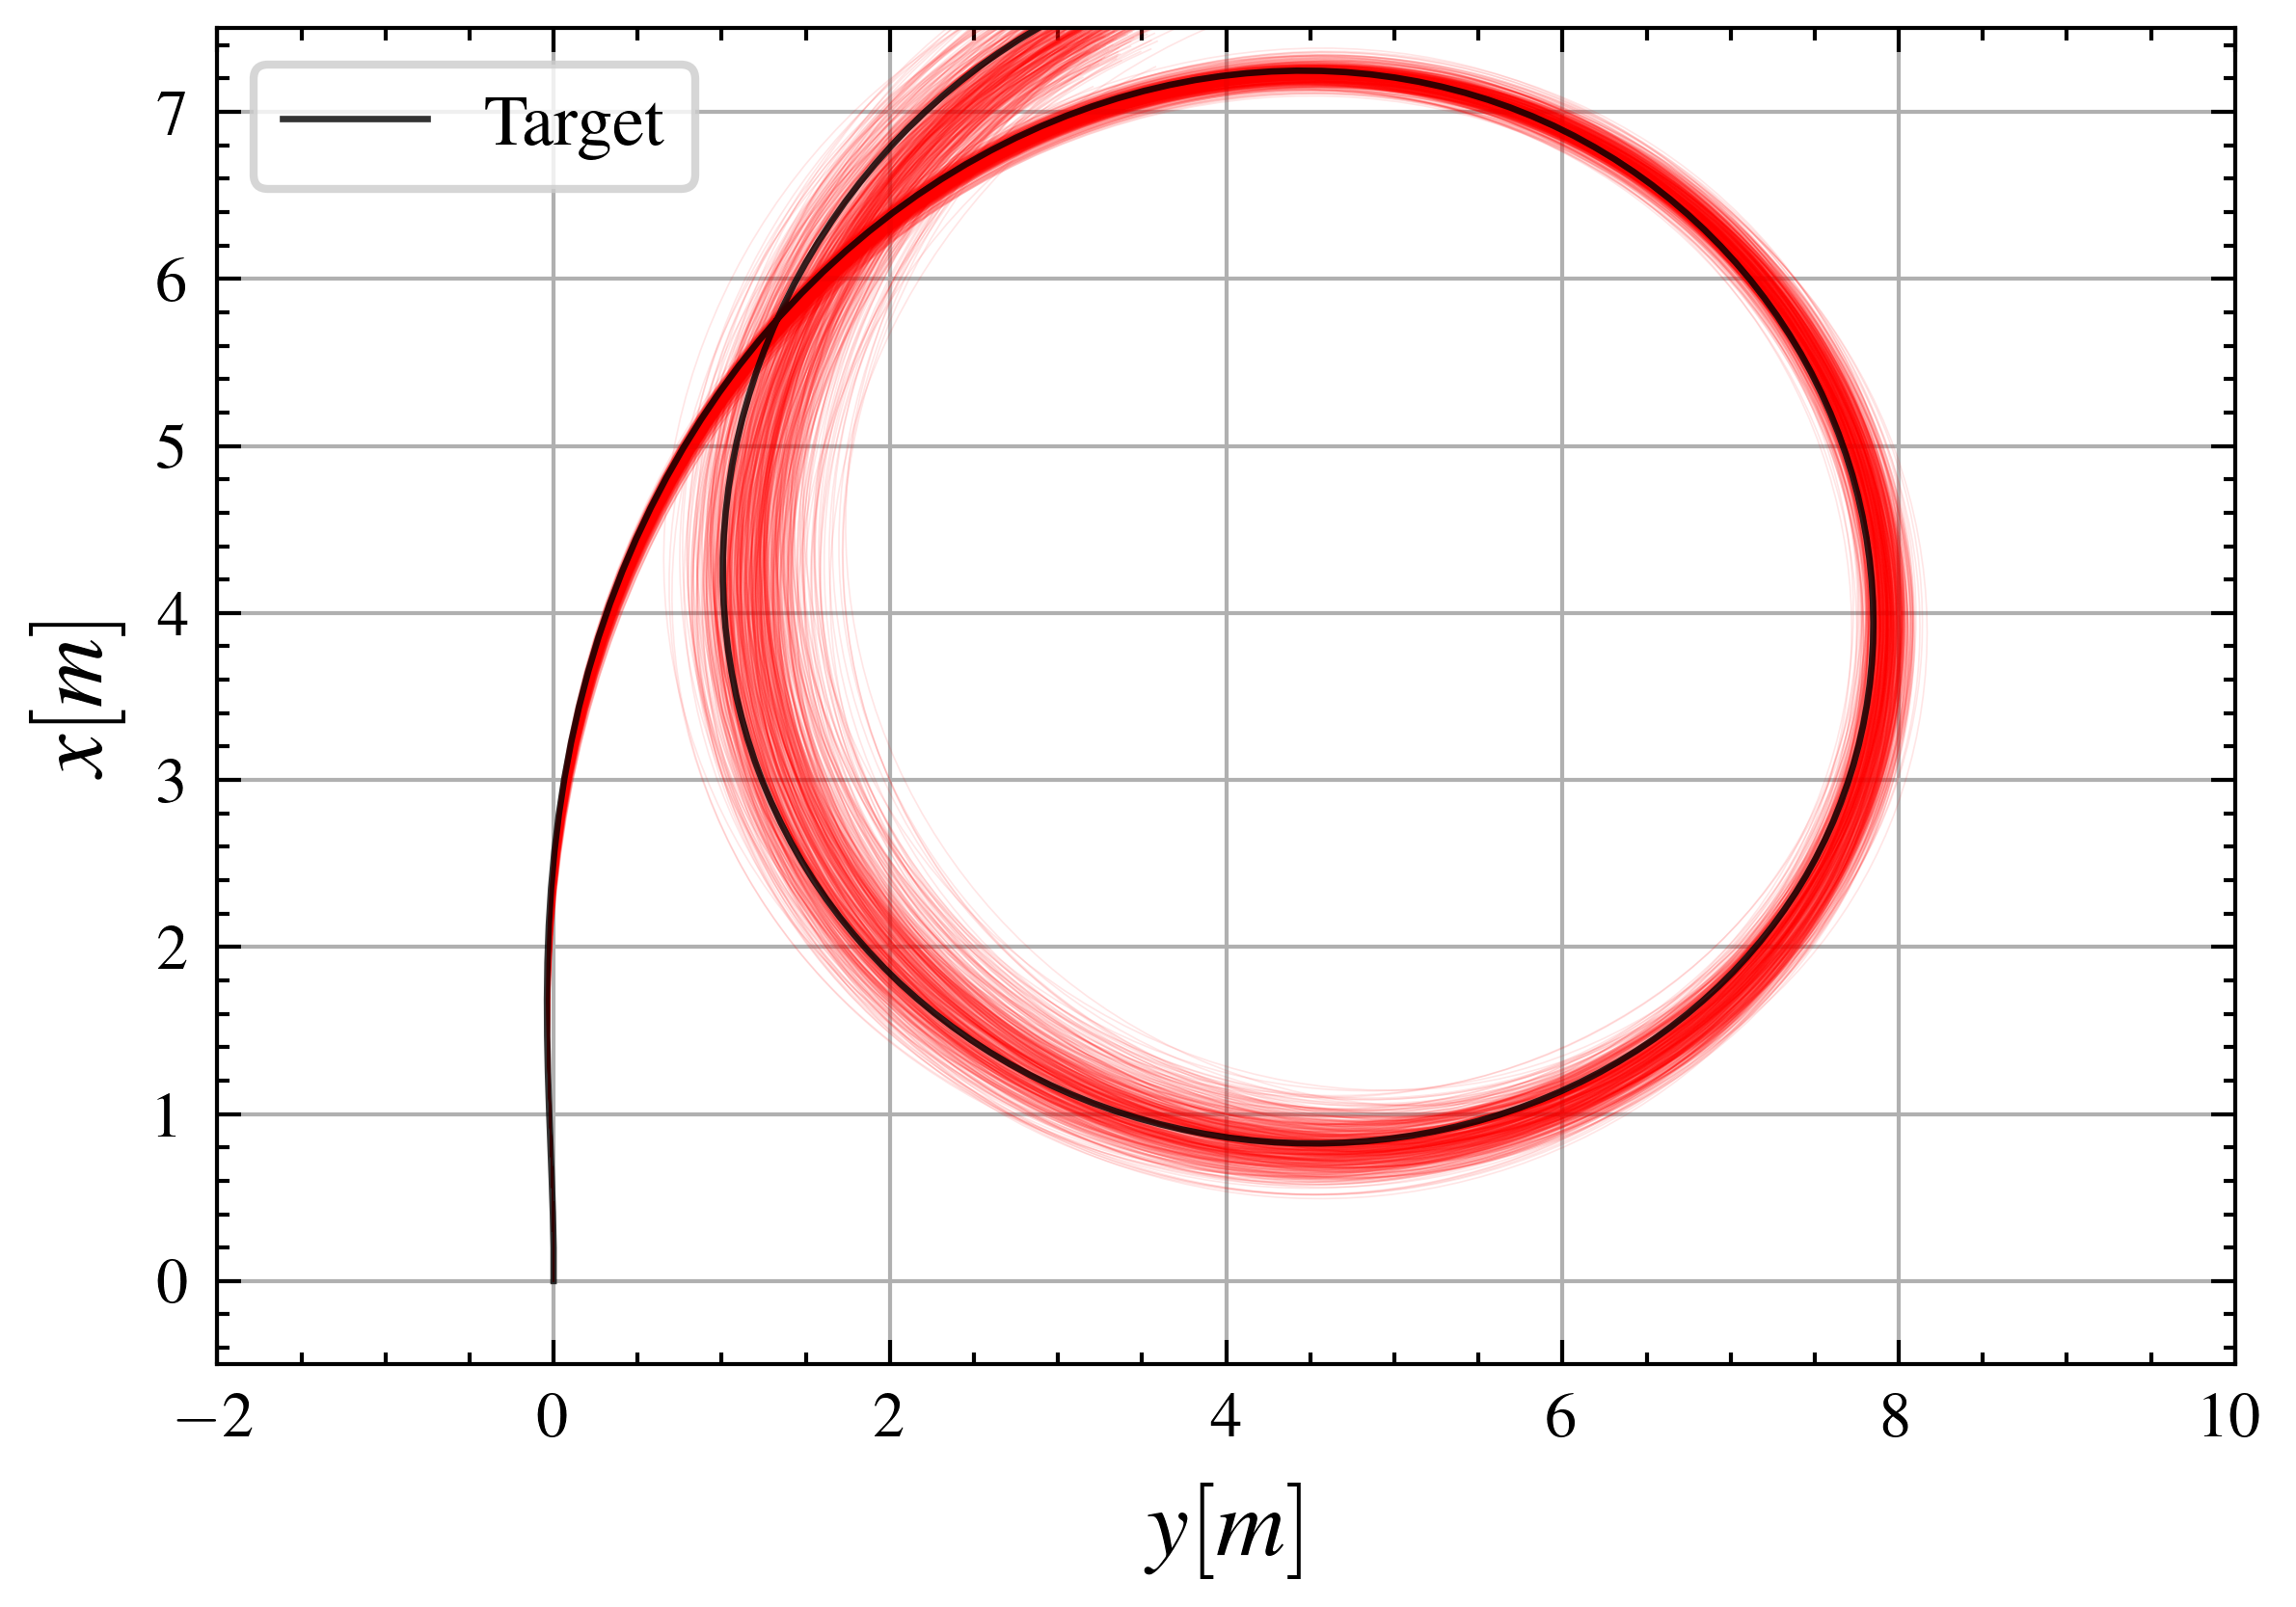

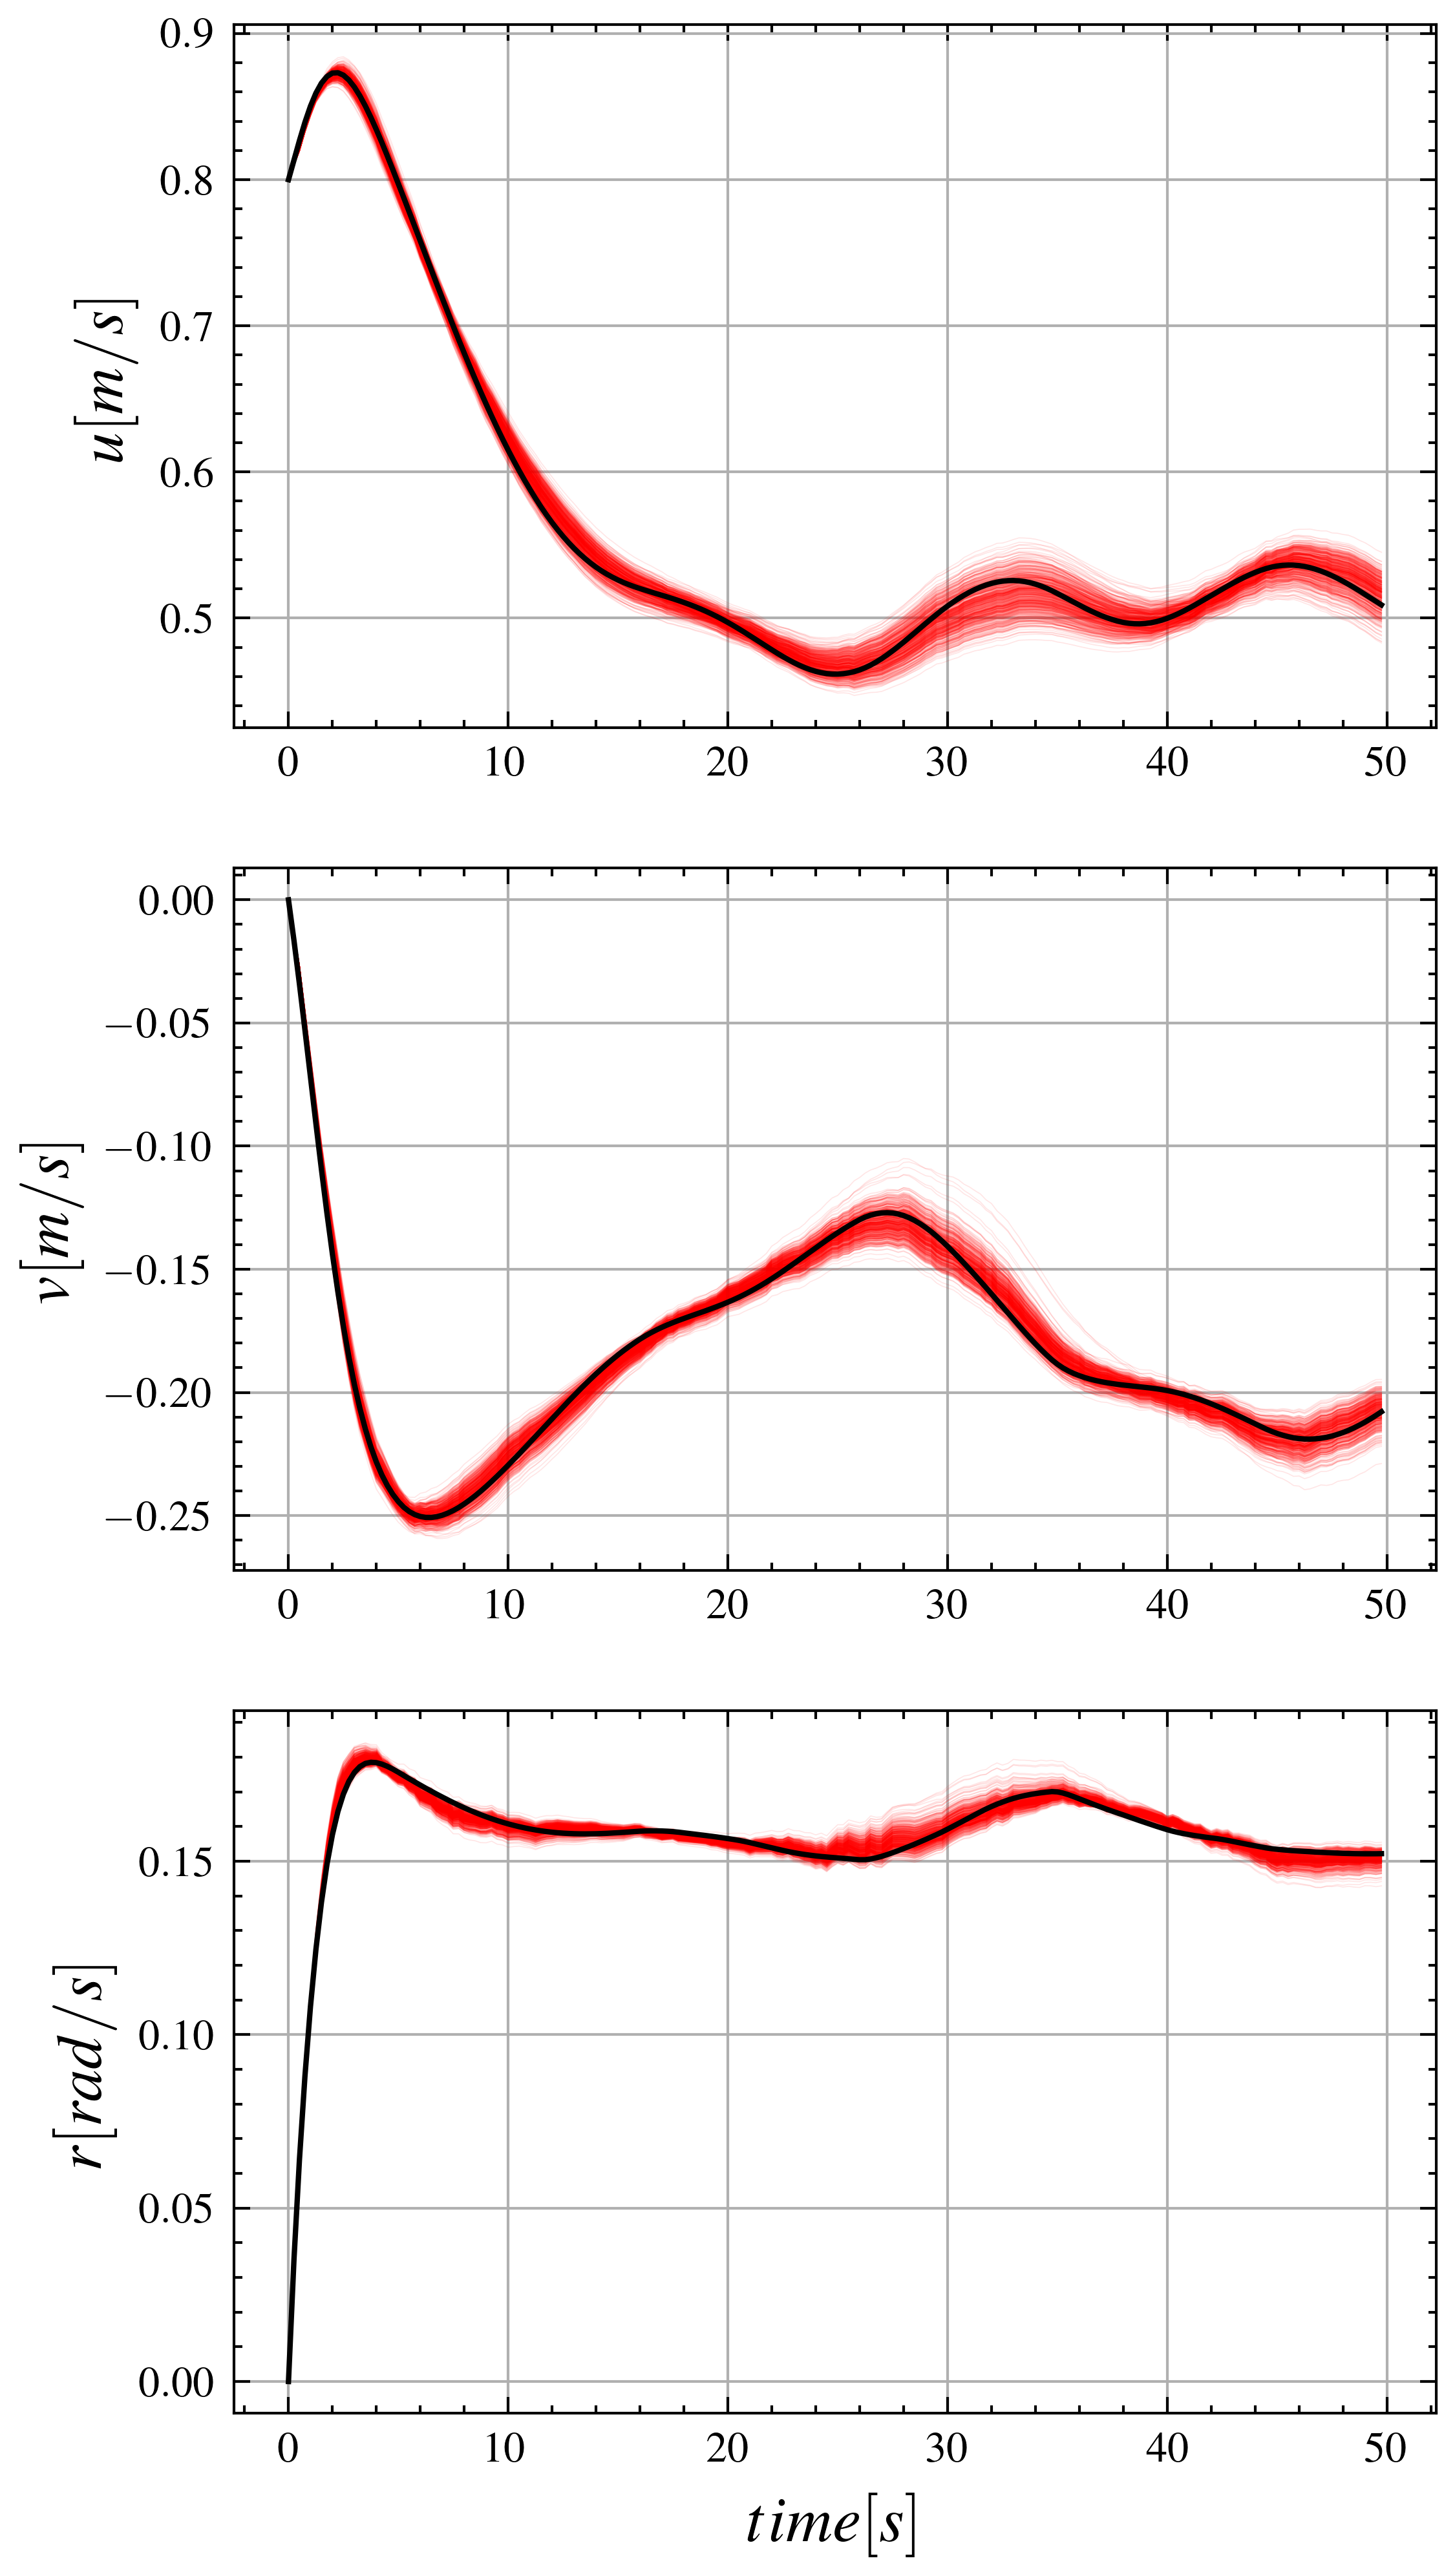

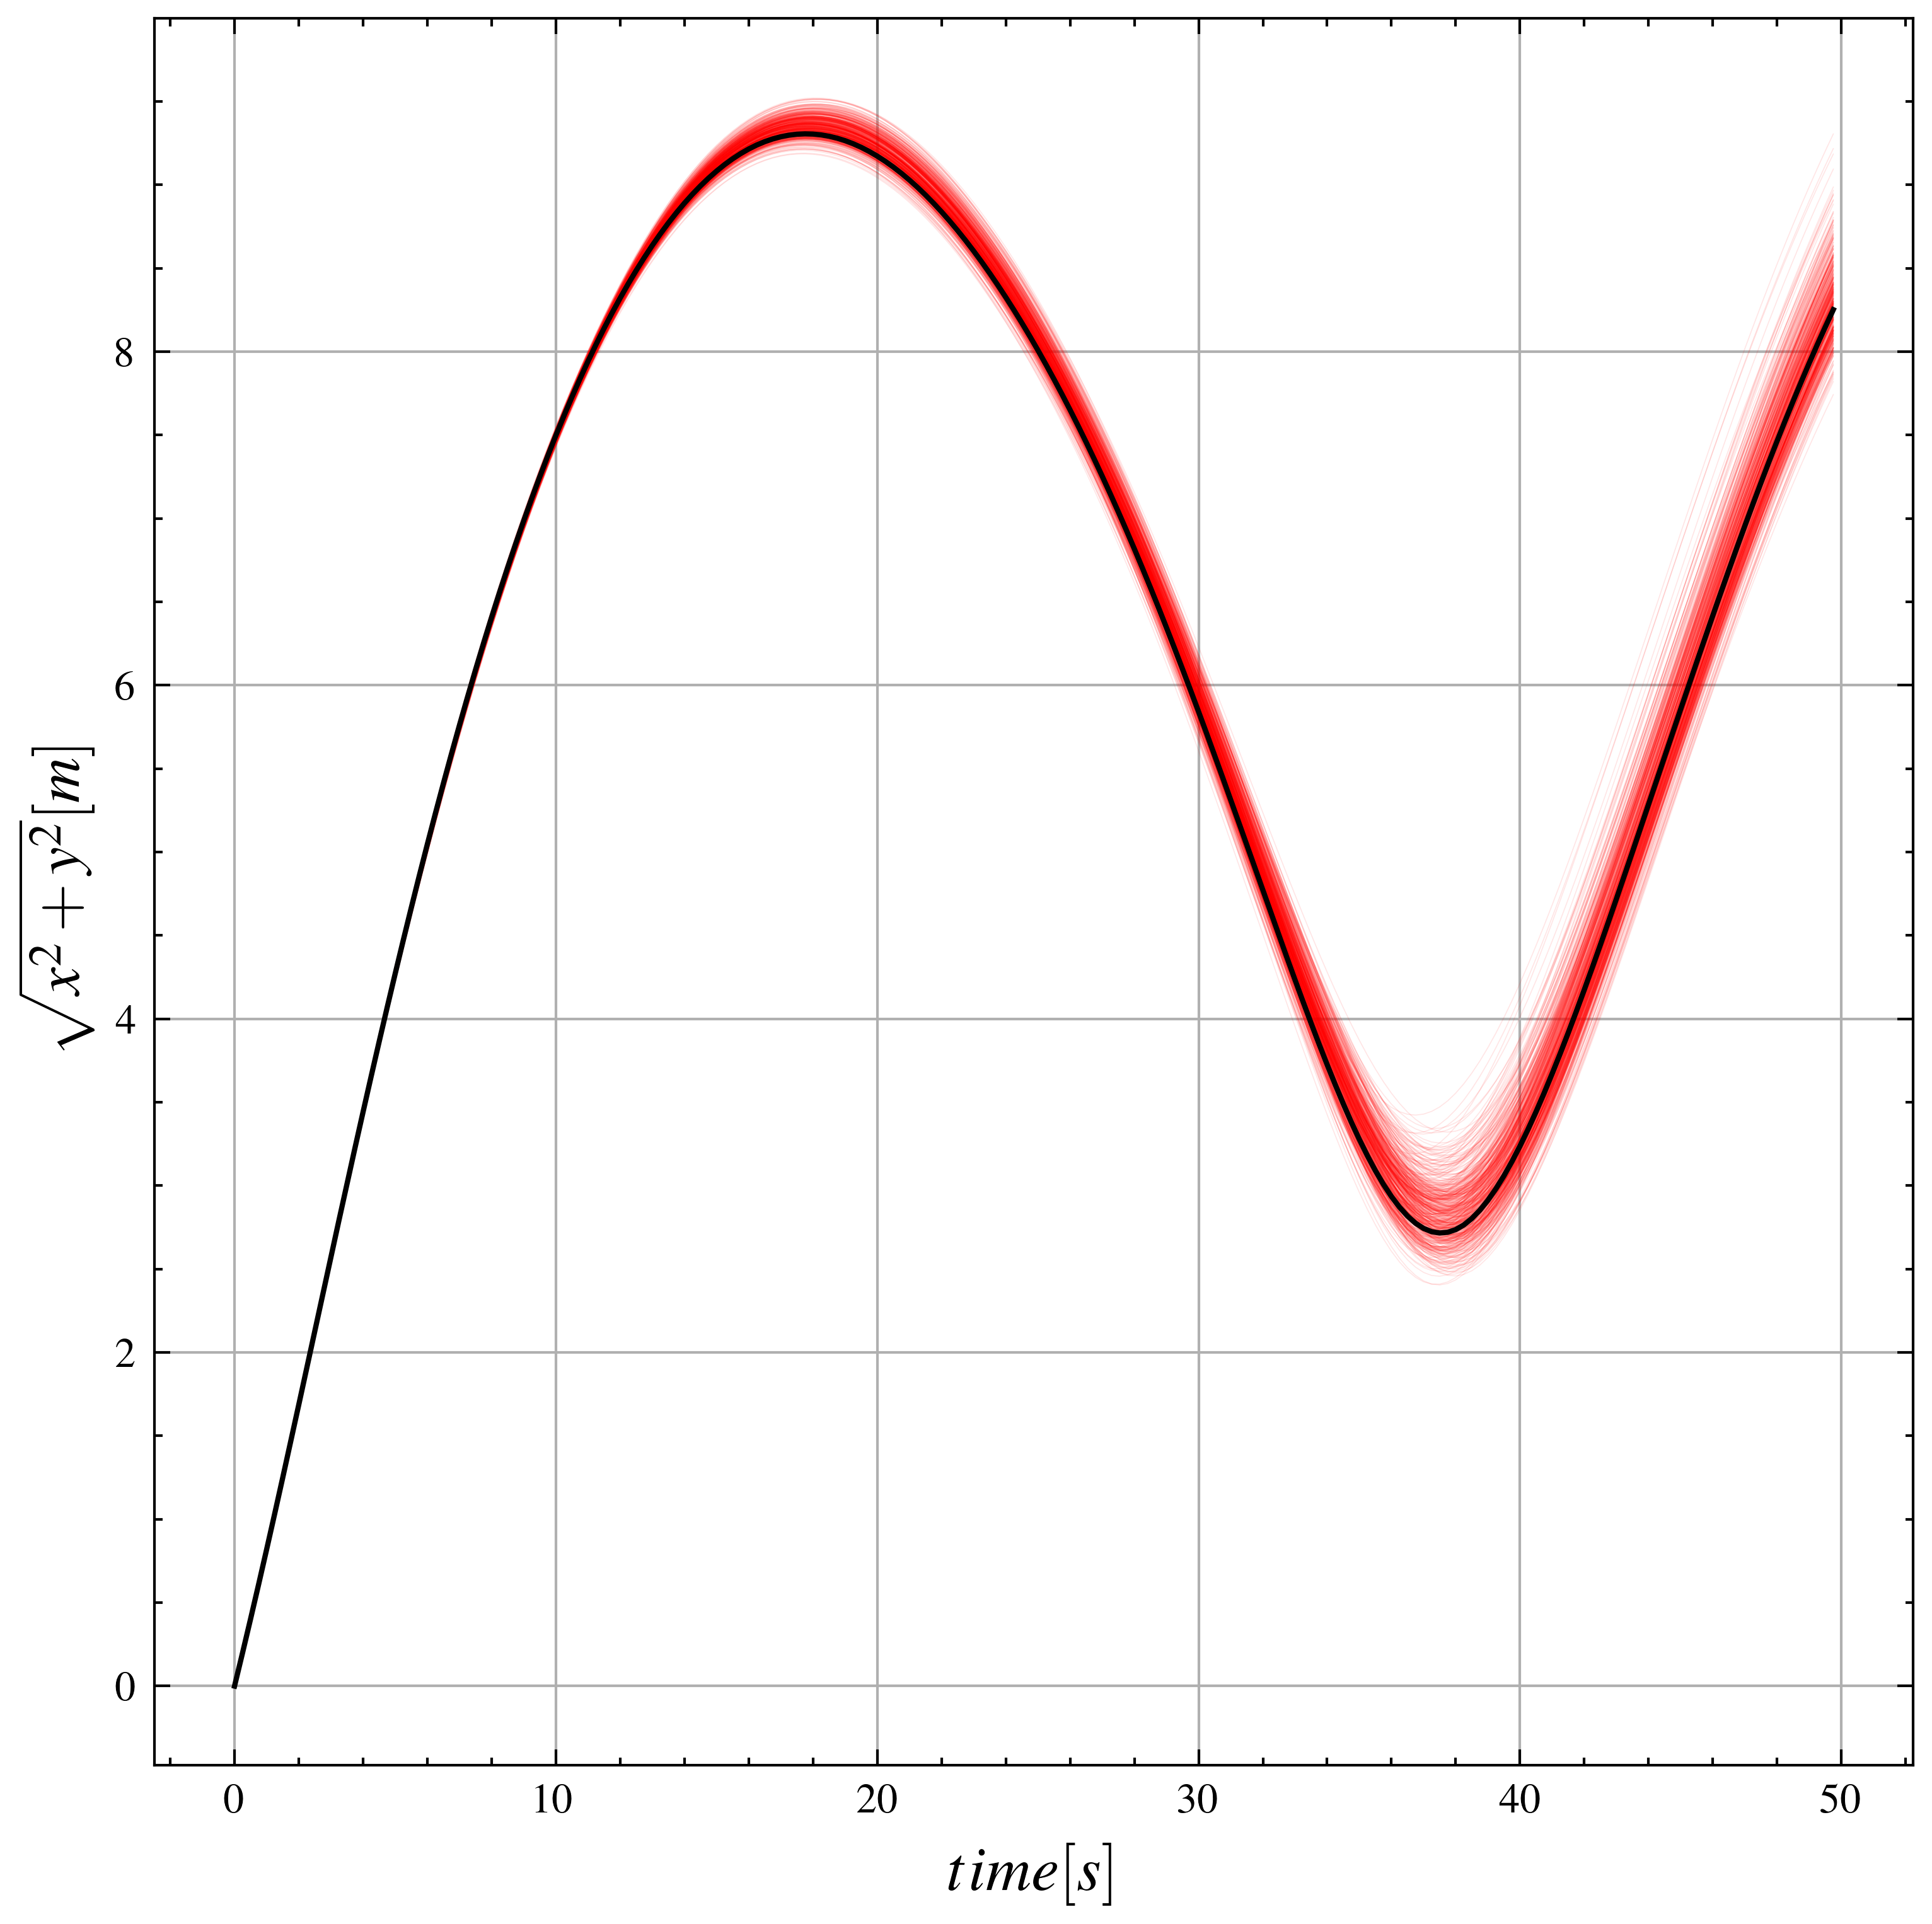

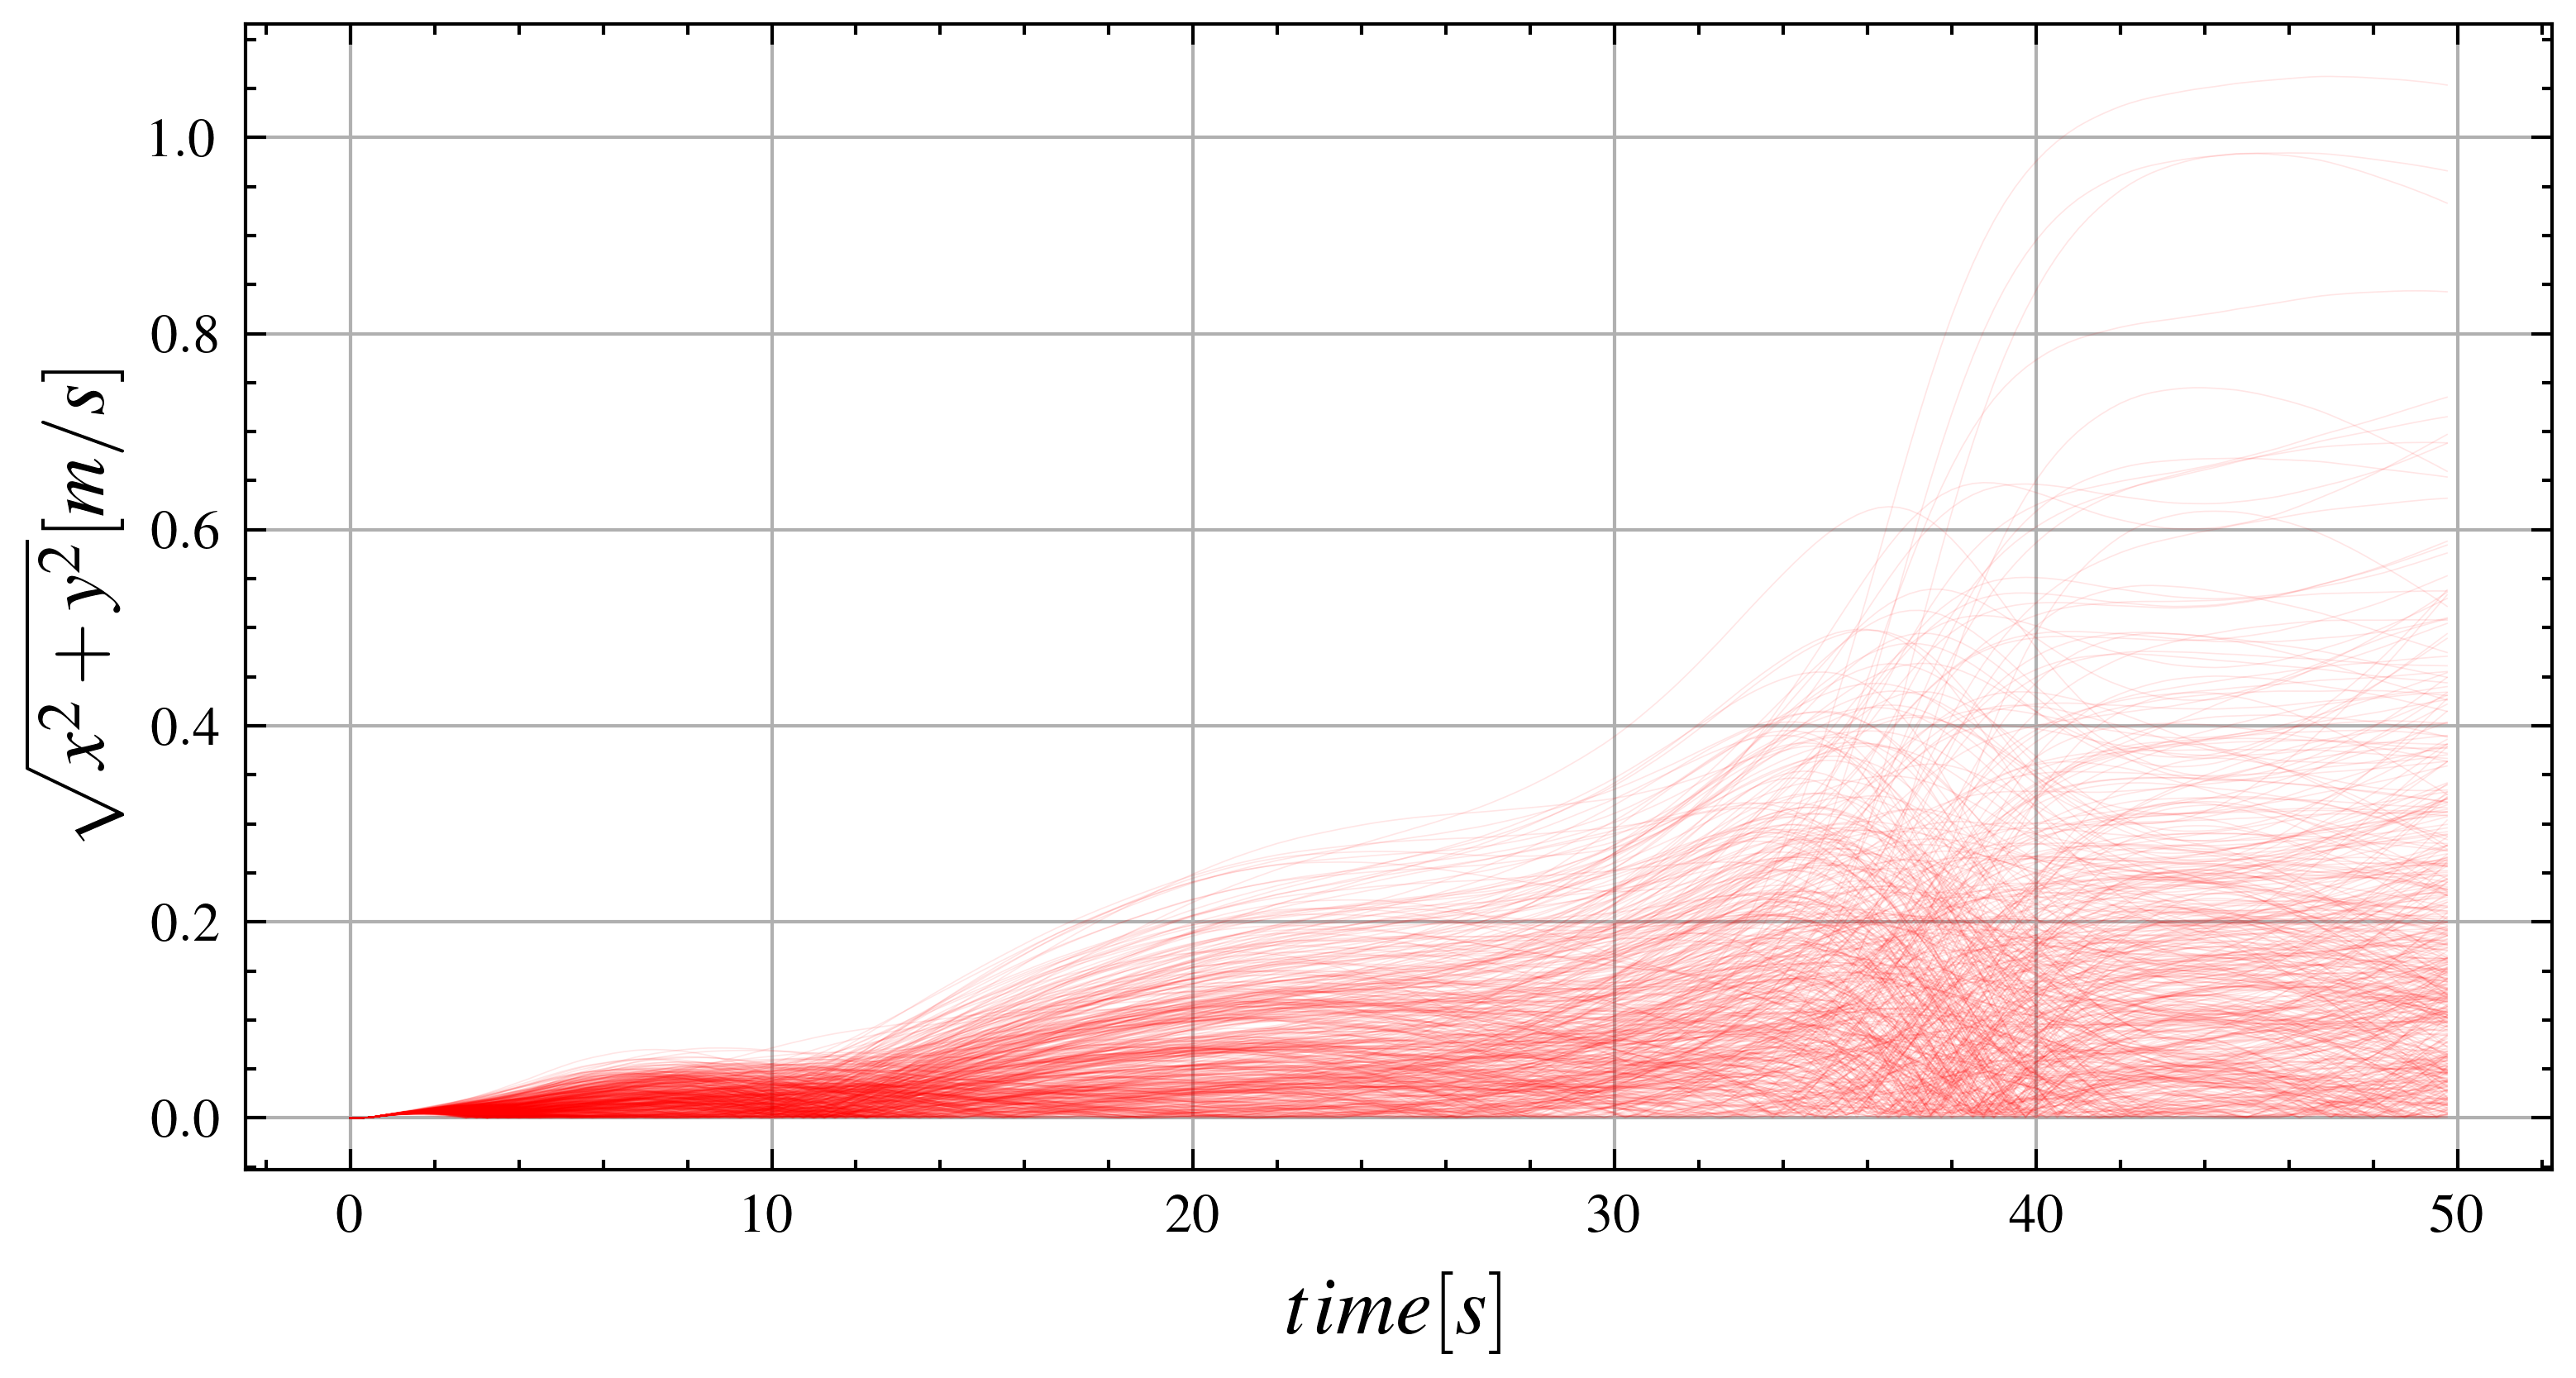

In [129]:
fig = plt.figure(figsize=(4.5, 3))
ax = fig.add_subplot(1, 1, 1)
for i in num1:num2
    ax.plot(results.data[i][1:sampling,"y"], results.data[i][1:sampling,"x"], "-", alpha=0.1,  c="r", linewidth=0.2)
end
ax.plot(obs[1:sampling,"y"], obs[1:sampling,"x"], "-", label="Target", c="k", alpha=0.8, linewidth=0.8)
ax.set_ylabel(L"x[m]", fontsize=12)
ax.set_xlabel(L"y[m]", fontsize=12)
ax.legend(frameon=true, loc="upper left", fontsize=9)
# ax.set_ylim(0, 10)
# ax.set_xlim(-3, 12)
# ax.set_ylim(-5, 13)
# ax.set_xlim(-7, 20)
ax.set_ylim(-0.5, 7.5)
ax.set_xlim(-2, 10)
ax.grid()
display(fig)

fig = plt.figure(figsize=(4,8))
ax = fig.add_subplot(3, 1, 1)
for i in num1:num2
    ax.plot(results.data[i][1:sampling,"time"], results.data[i][1:sampling,"u"], "-", c="r", alpha=0.1, linewidth=0.2)
end
ax.plot(obs[1:sampling,"time"], obs[1:sampling,"u"], "-", c="k", linewidth=1)
ax.set_ylabel(L"u[m/s]", fontsize=12)
ax.grid()
ax = fig.add_subplot(3, 1, 2)
for i in num1:num2
    ax.plot(results.data[i][1:sampling,"time"], results.data[i][1:sampling,"v"], "-", c="r", alpha=0.1, linewidth=0.2)
end
ax.plot(obs[1:sampling,"time"], obs[1:sampling,"v"], "-", c="k", linewidth=1)
ax.set_ylabel(L"v[m/s]", fontsize=12)
ax.grid()
ax = fig.add_subplot(3, 1, 3)
for i in num1:num2
    ax.plot(results.data[i][1:sampling,"time"], results.data[i][1:sampling,"r"], "-", c="r", alpha=0.1, linewidth=0.2)
end
ax.plot(obs[1:sampling,"time"], obs[1:sampling,"r"], "-", c="k", linewidth=1)
ax.set_ylabel(L"r[rad/s]", fontsize=12)
ax.set_xlabel(L"time[s]", fontsize=12)
ax.grid()
display(fig)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
for i in num1:num2
    ax.plot(results.data[i][1:sampling,"time"], sqrt.(results.data[i][1:sampling,"x"].^2 + results.data[i][1:sampling,"y"].^2), "-", c="r", alpha=0.1, linewidth=0.2)
end
ax.plot(obs[1:sampling,"time"], sqrt.(obs[1:sampling,"x"].^2 + obs[1:sampling,"y"].^2), "-", c="k", linewidth=1)
ax.set_ylabel(L"\sqrt{x^2+y^2}[m]", fontsize=12)
ax.set_xlabel(L"time[s]", fontsize=12)
ax.grid()
display(fig)

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(1, 1, 1)
for i in num1:num2
    ax.plot(results.data[i][1:sampling,"time"], abs.(sqrt.(results.data[i][1:sampling,"x"].^2 + results.data[i][1:sampling,"y"].^2)-sqrt.(obs[1:sampling,"x"].^2 + obs[1:sampling,"y"].^2)), "-", c="r", alpha=0.1, linewidth=0.2)
end
ax.set_ylabel(L"\sqrt{x^2+y^2}[m/s]", fontsize=12)
ax.set_xlabel(L"time[s]", fontsize=12)
ax.grid()
display(fig)

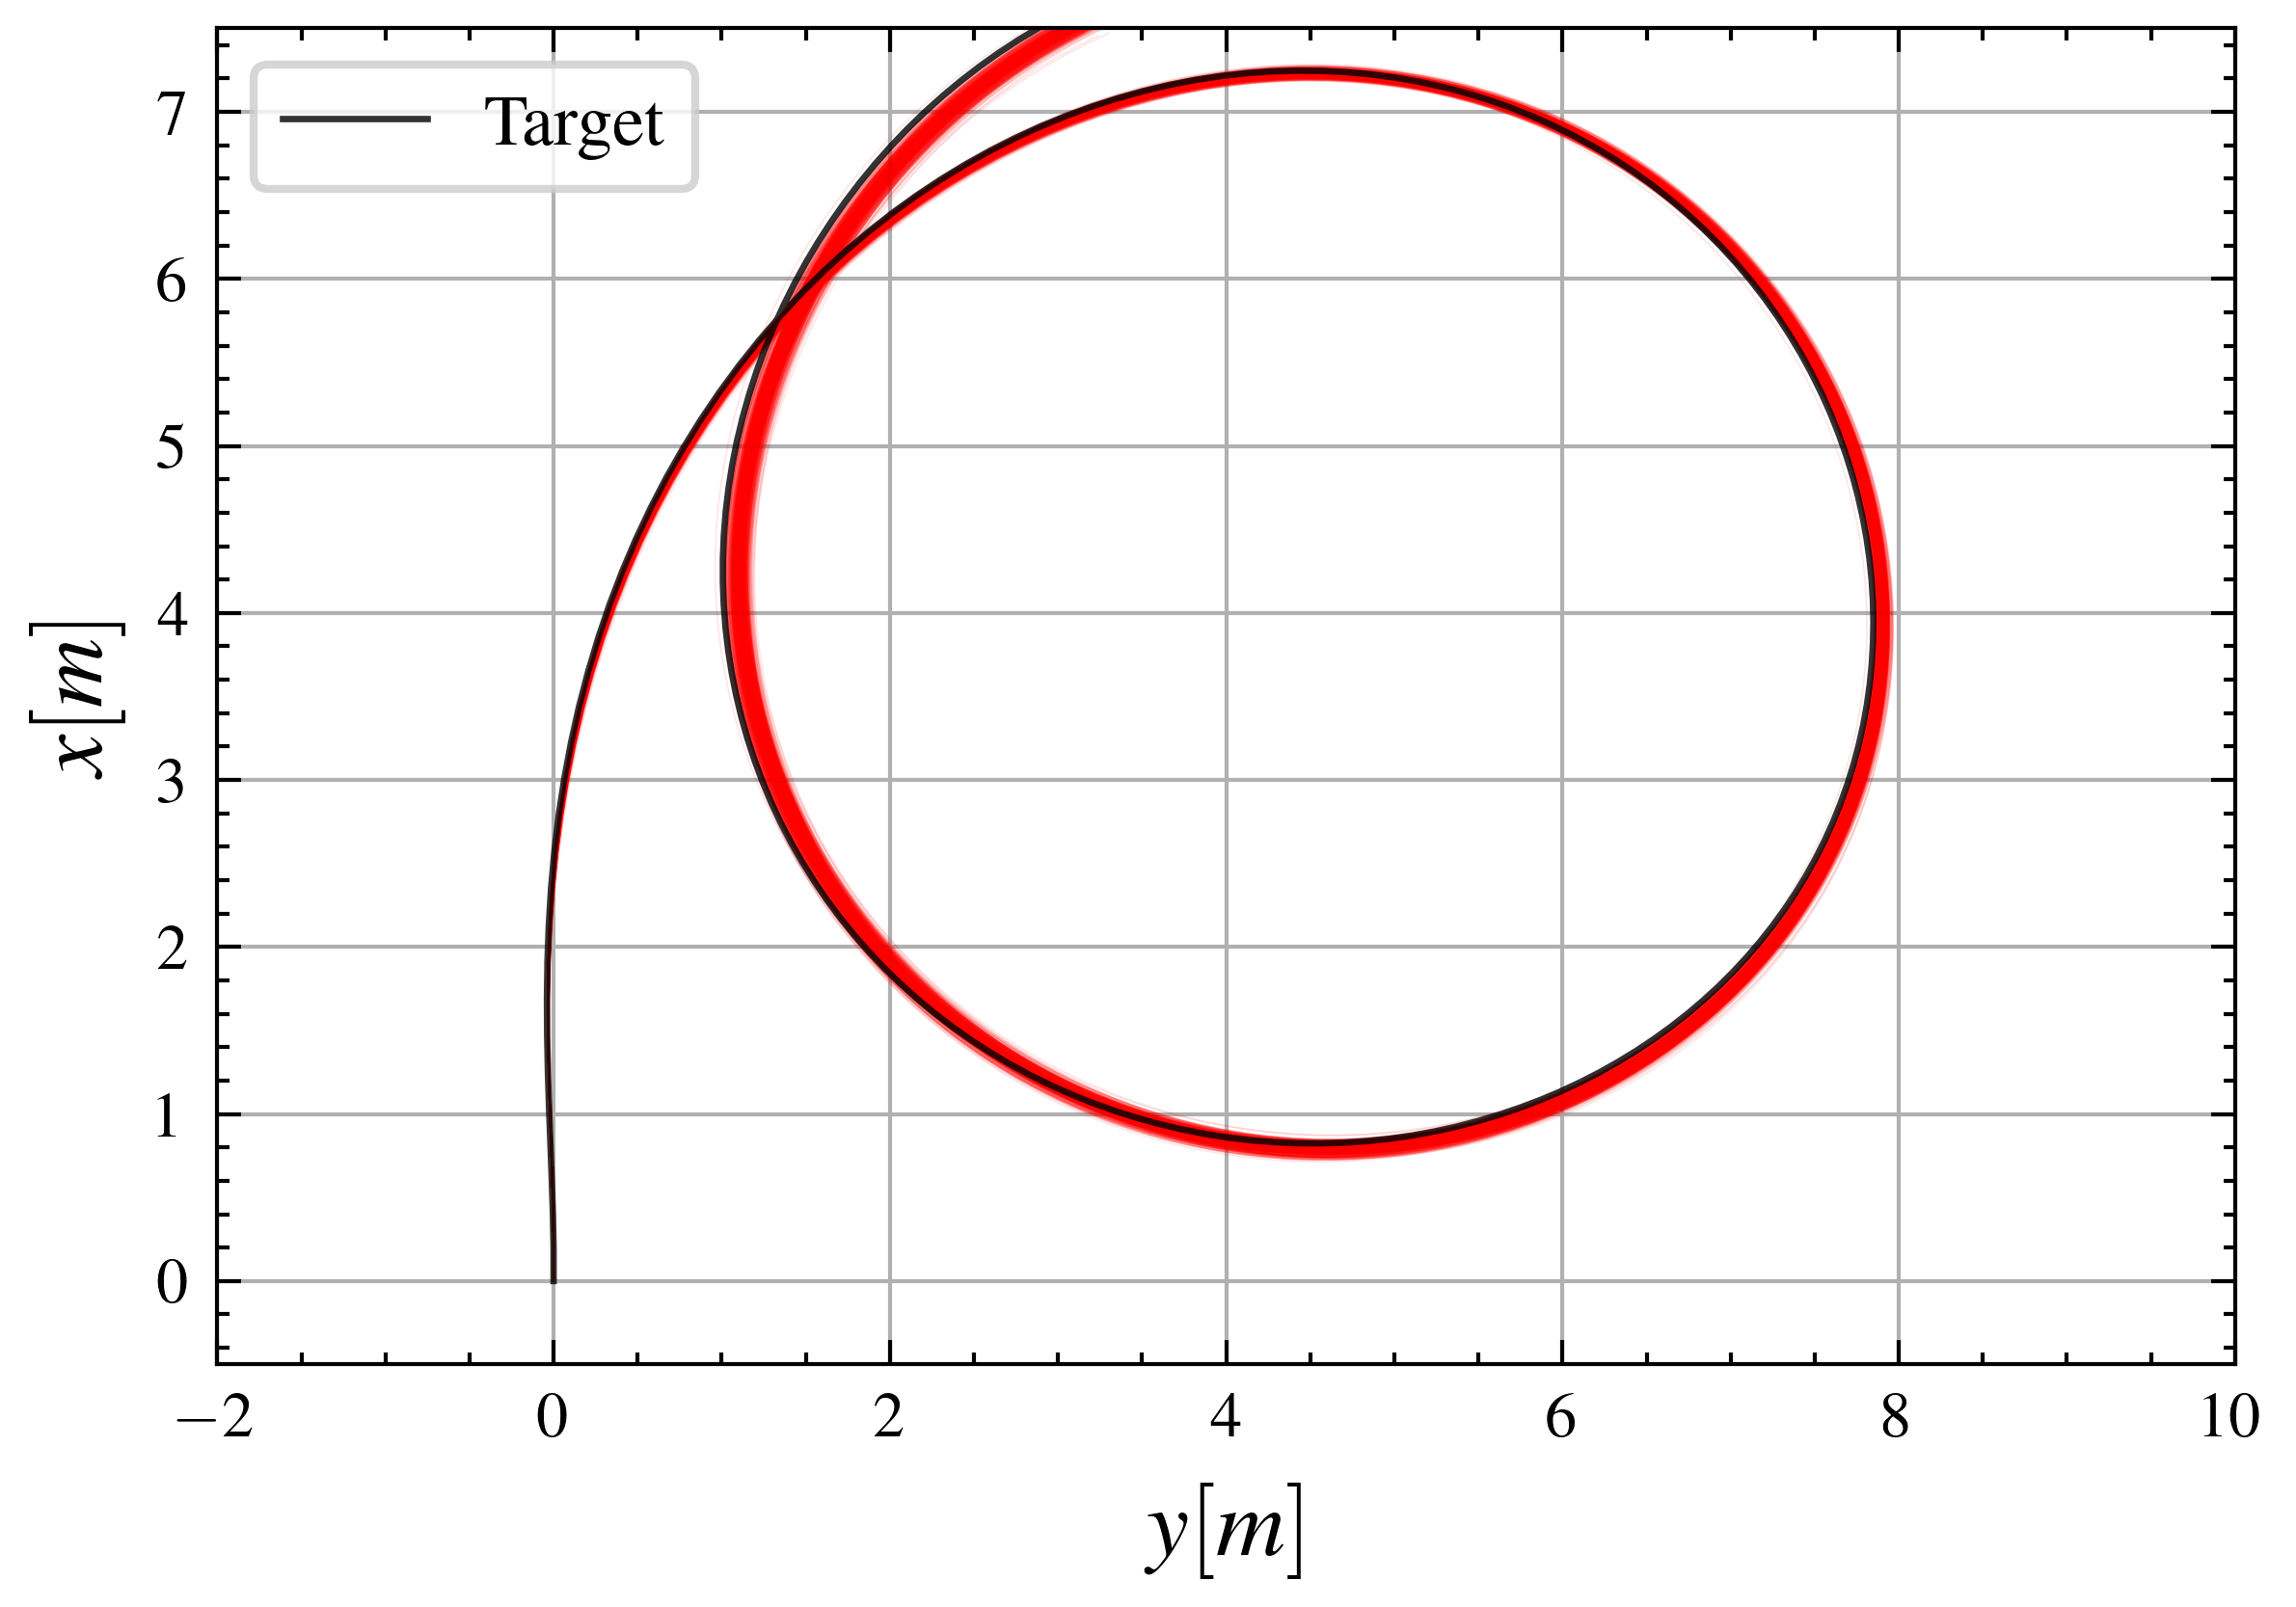

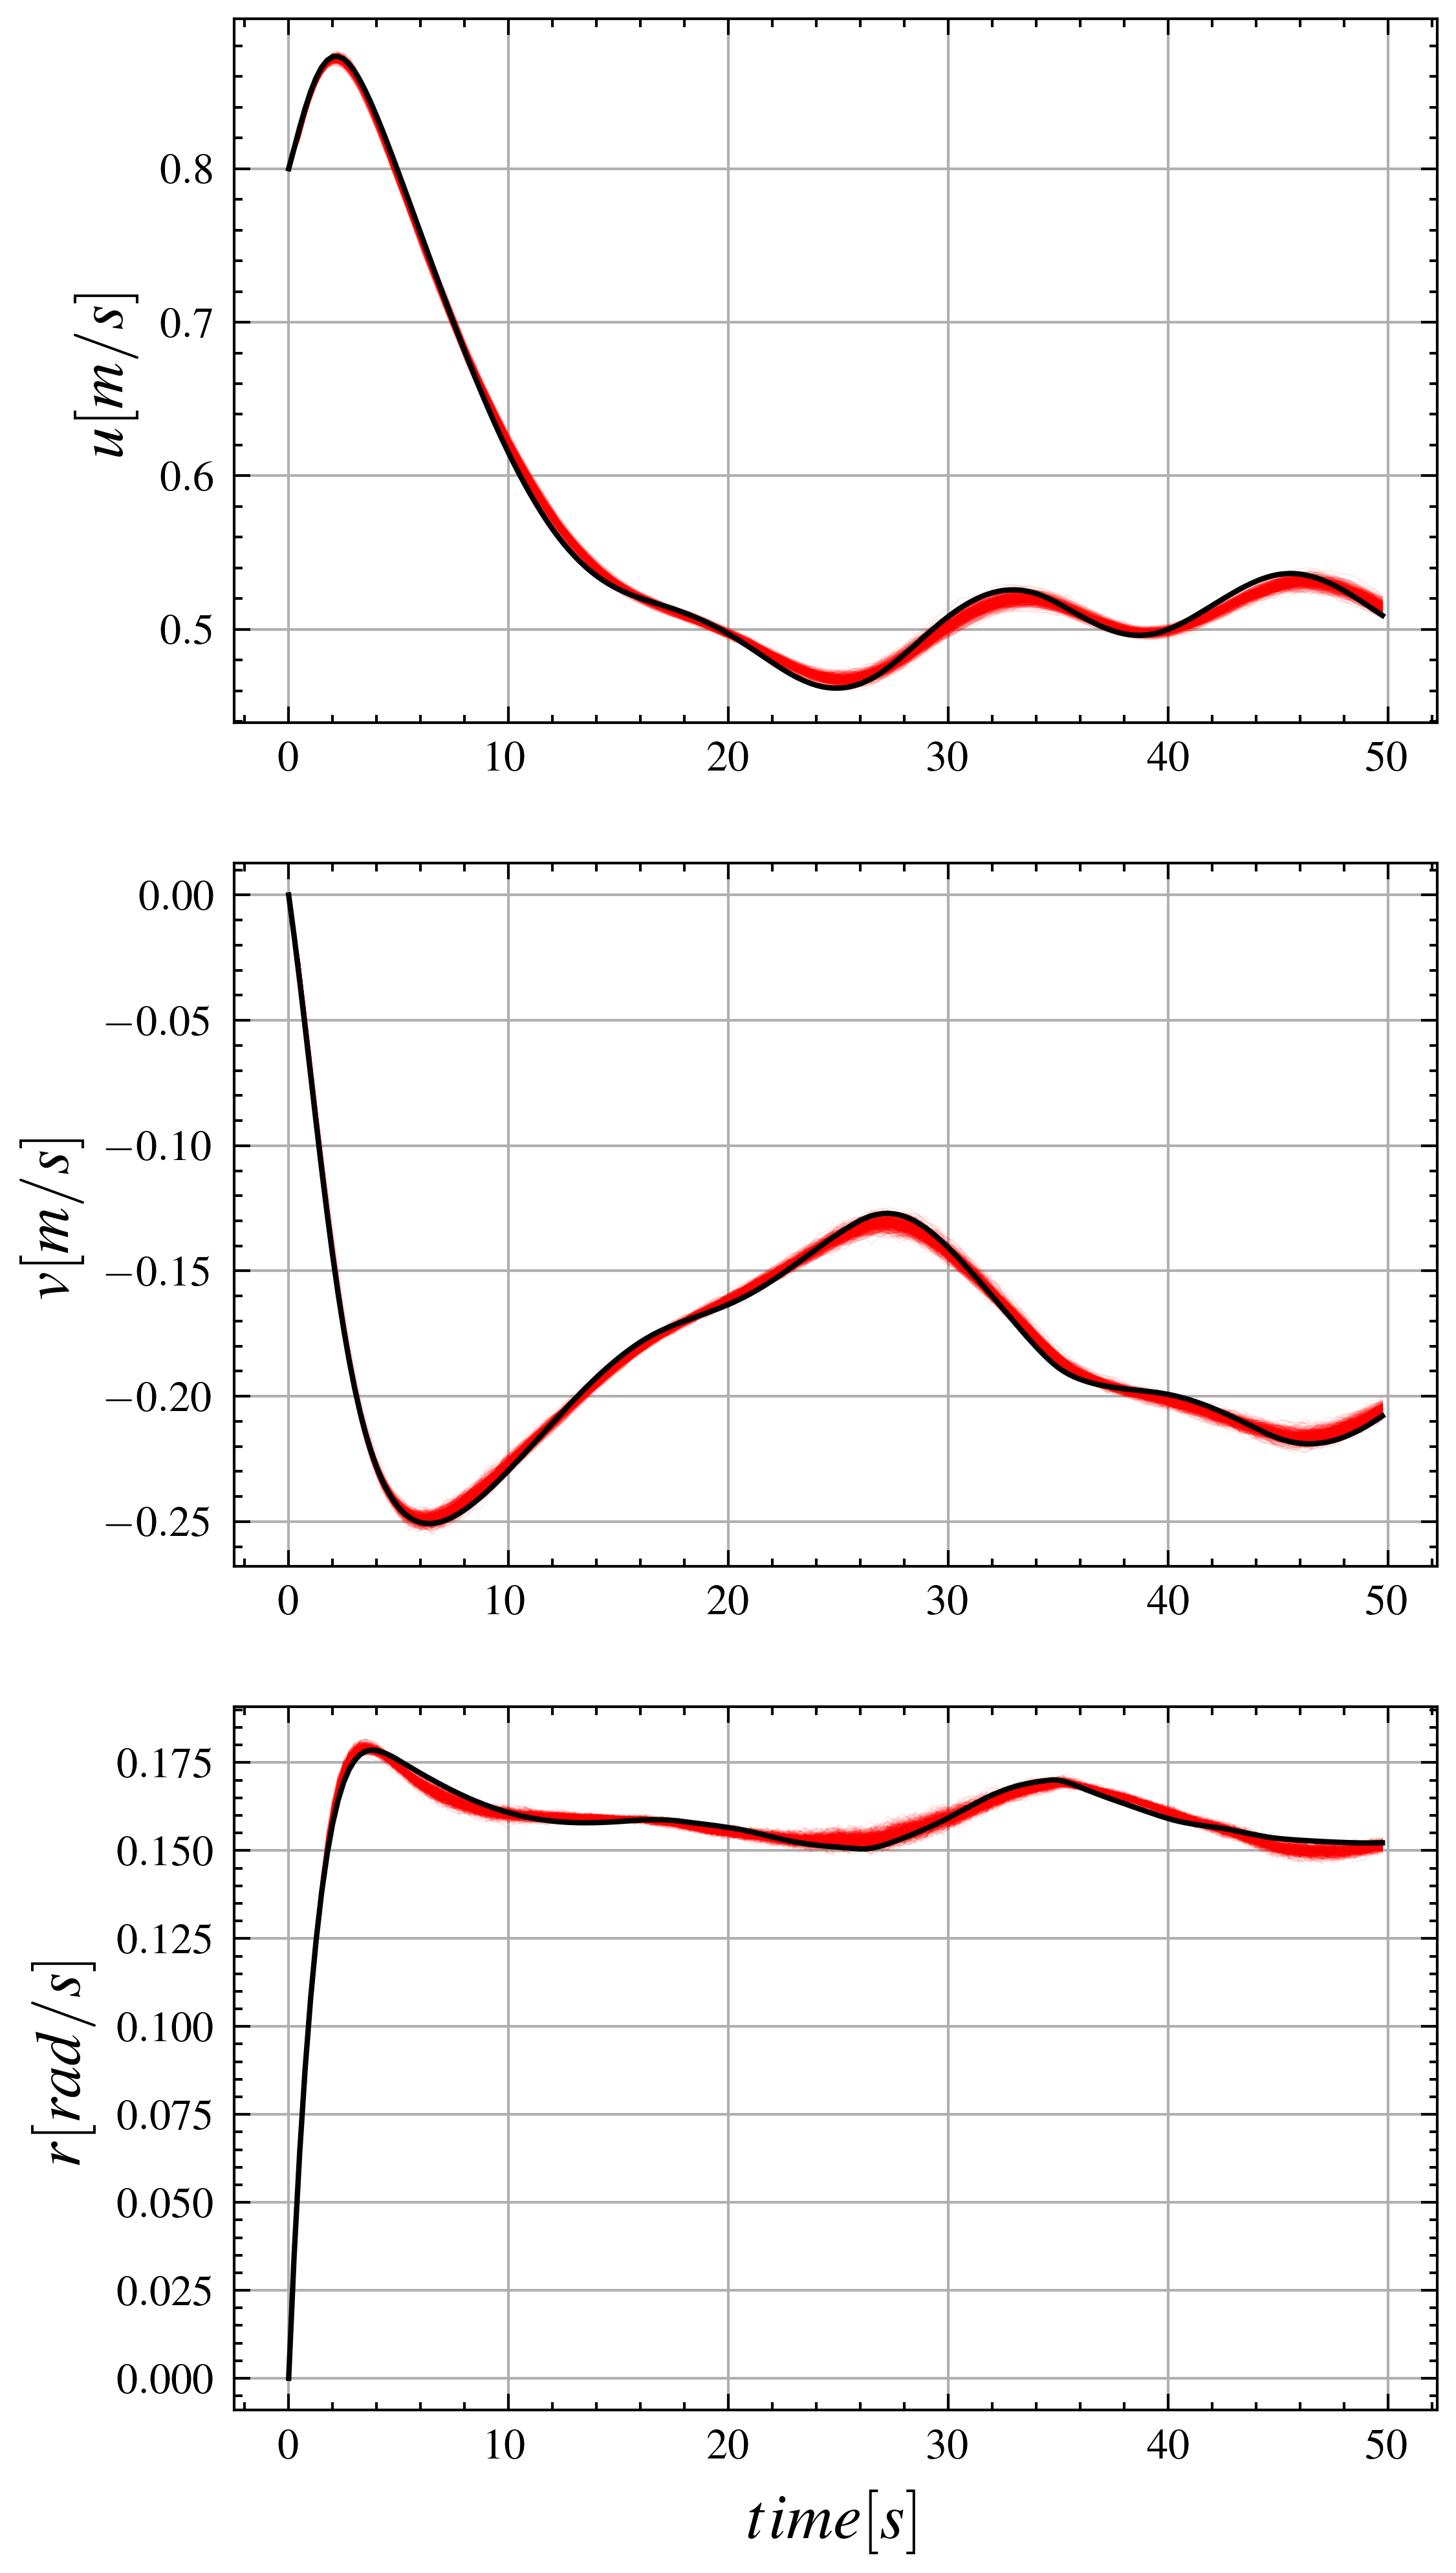

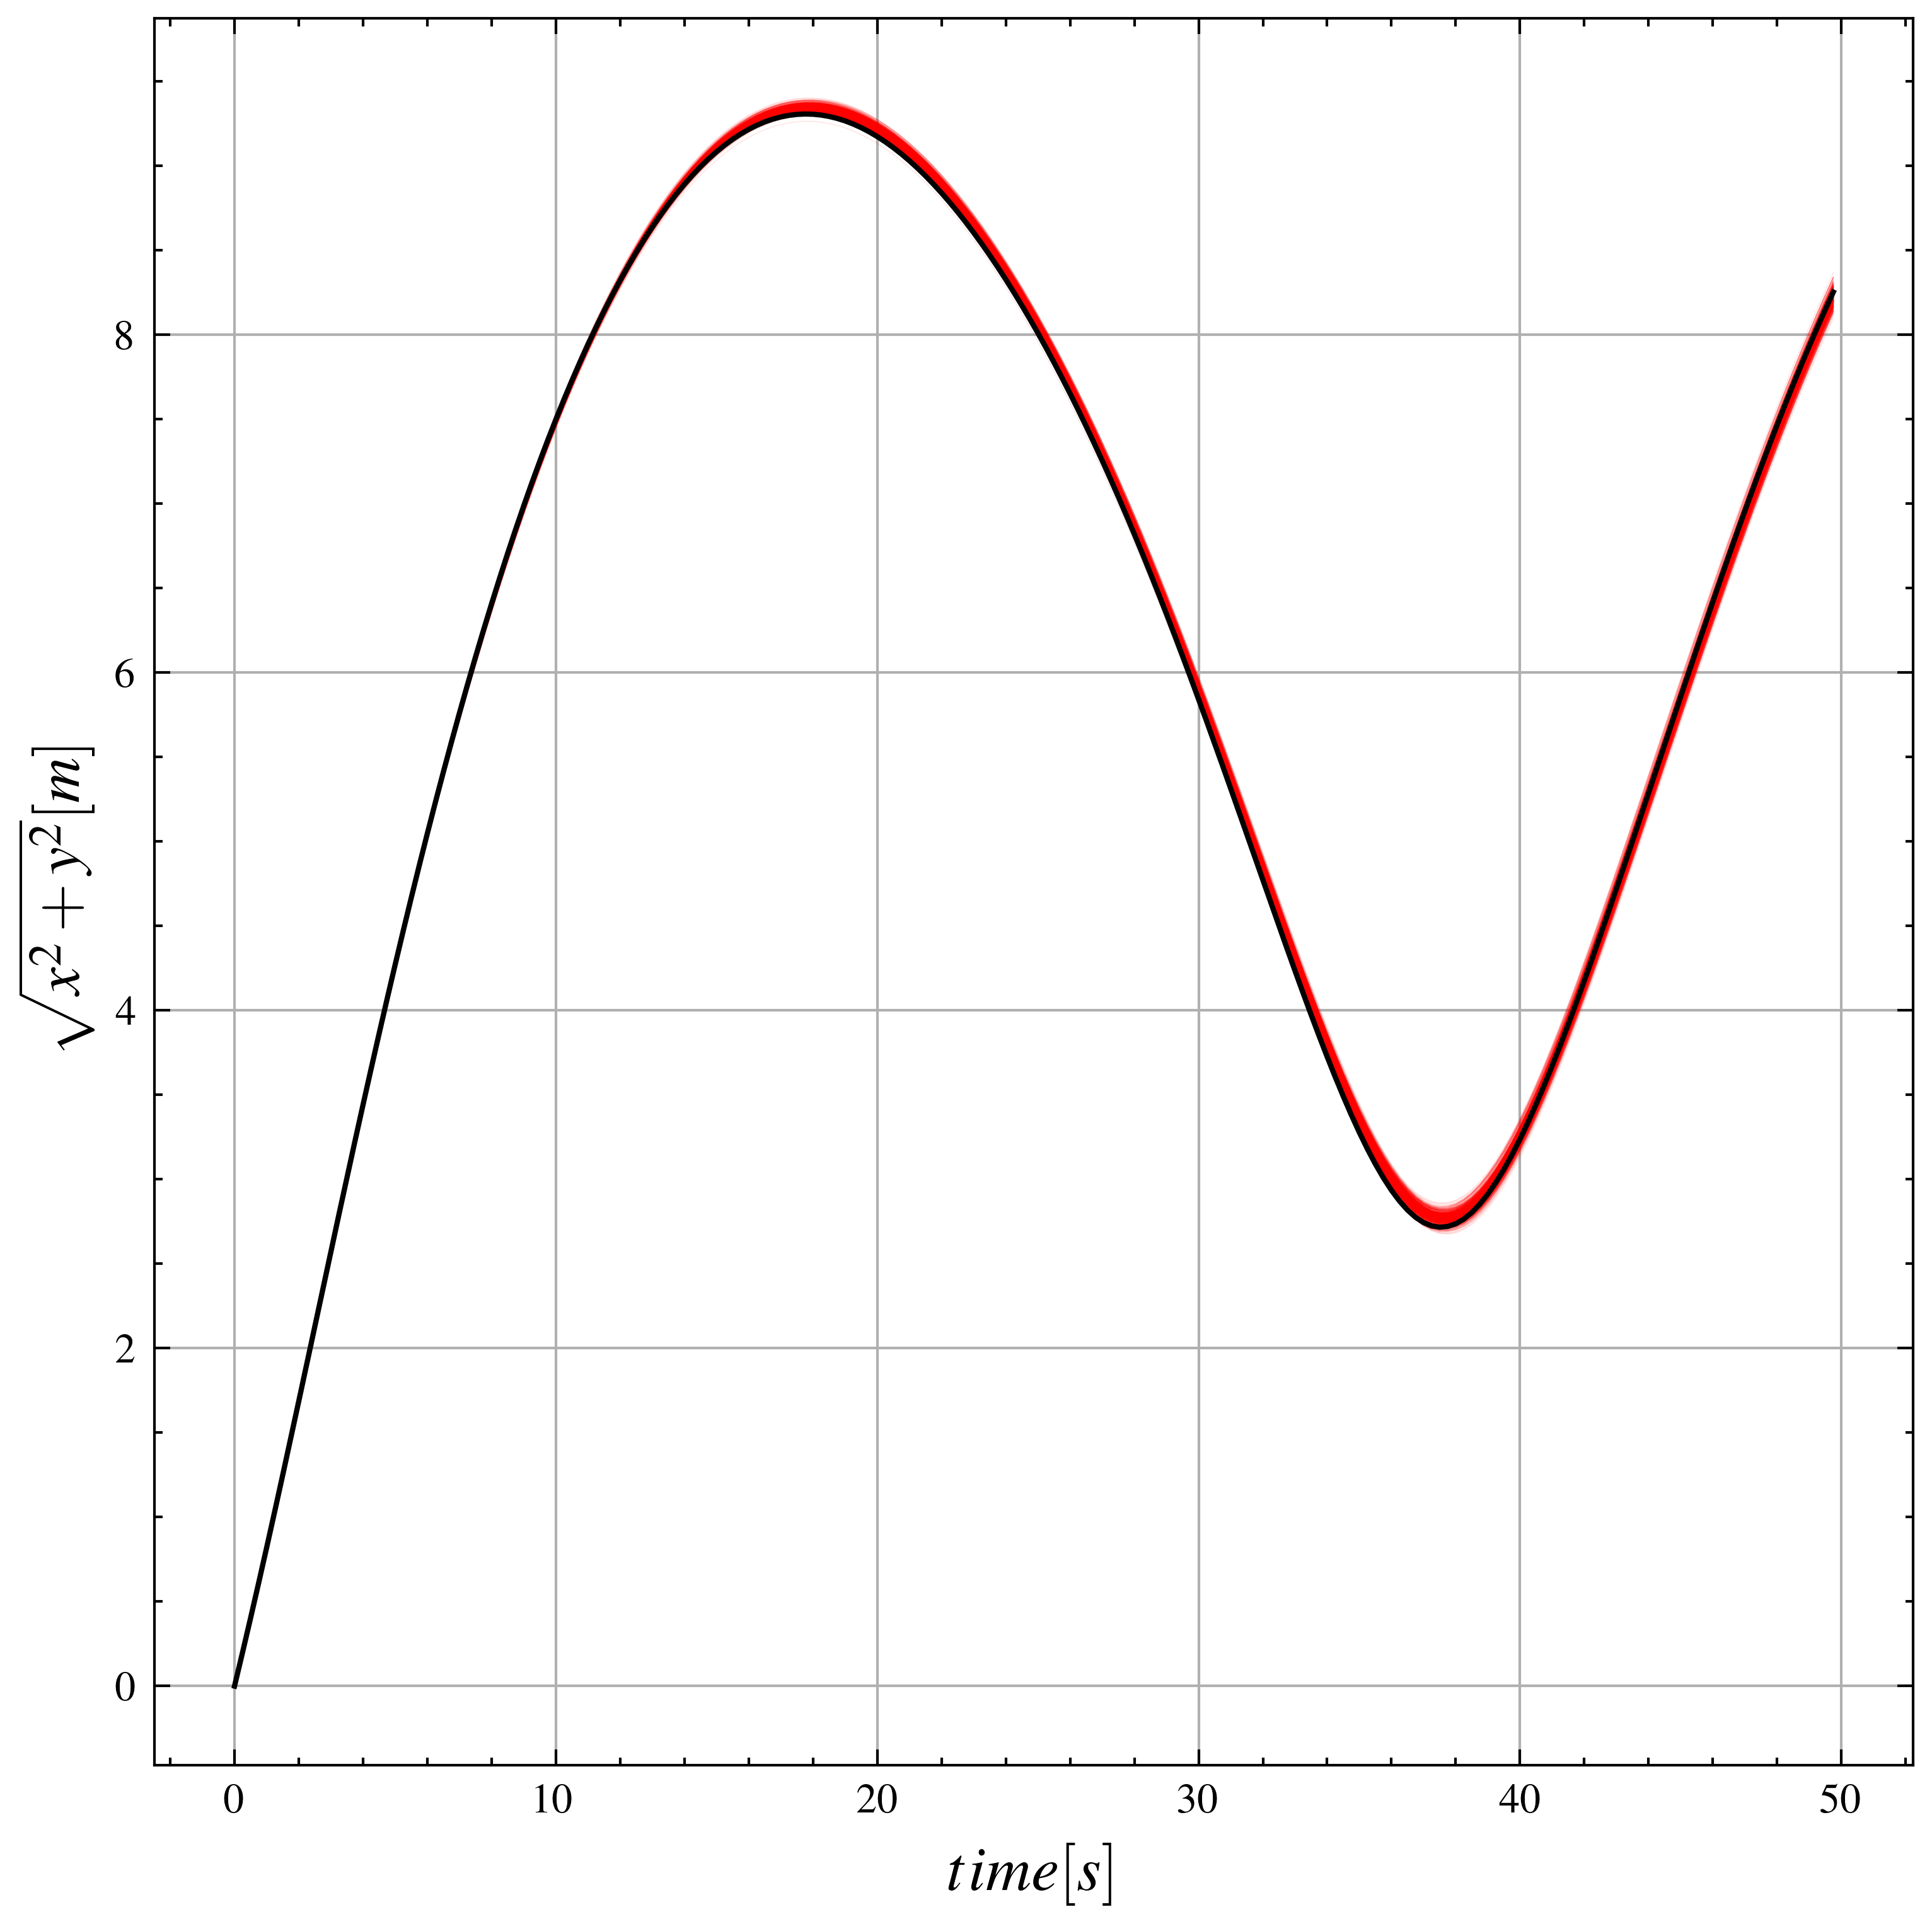

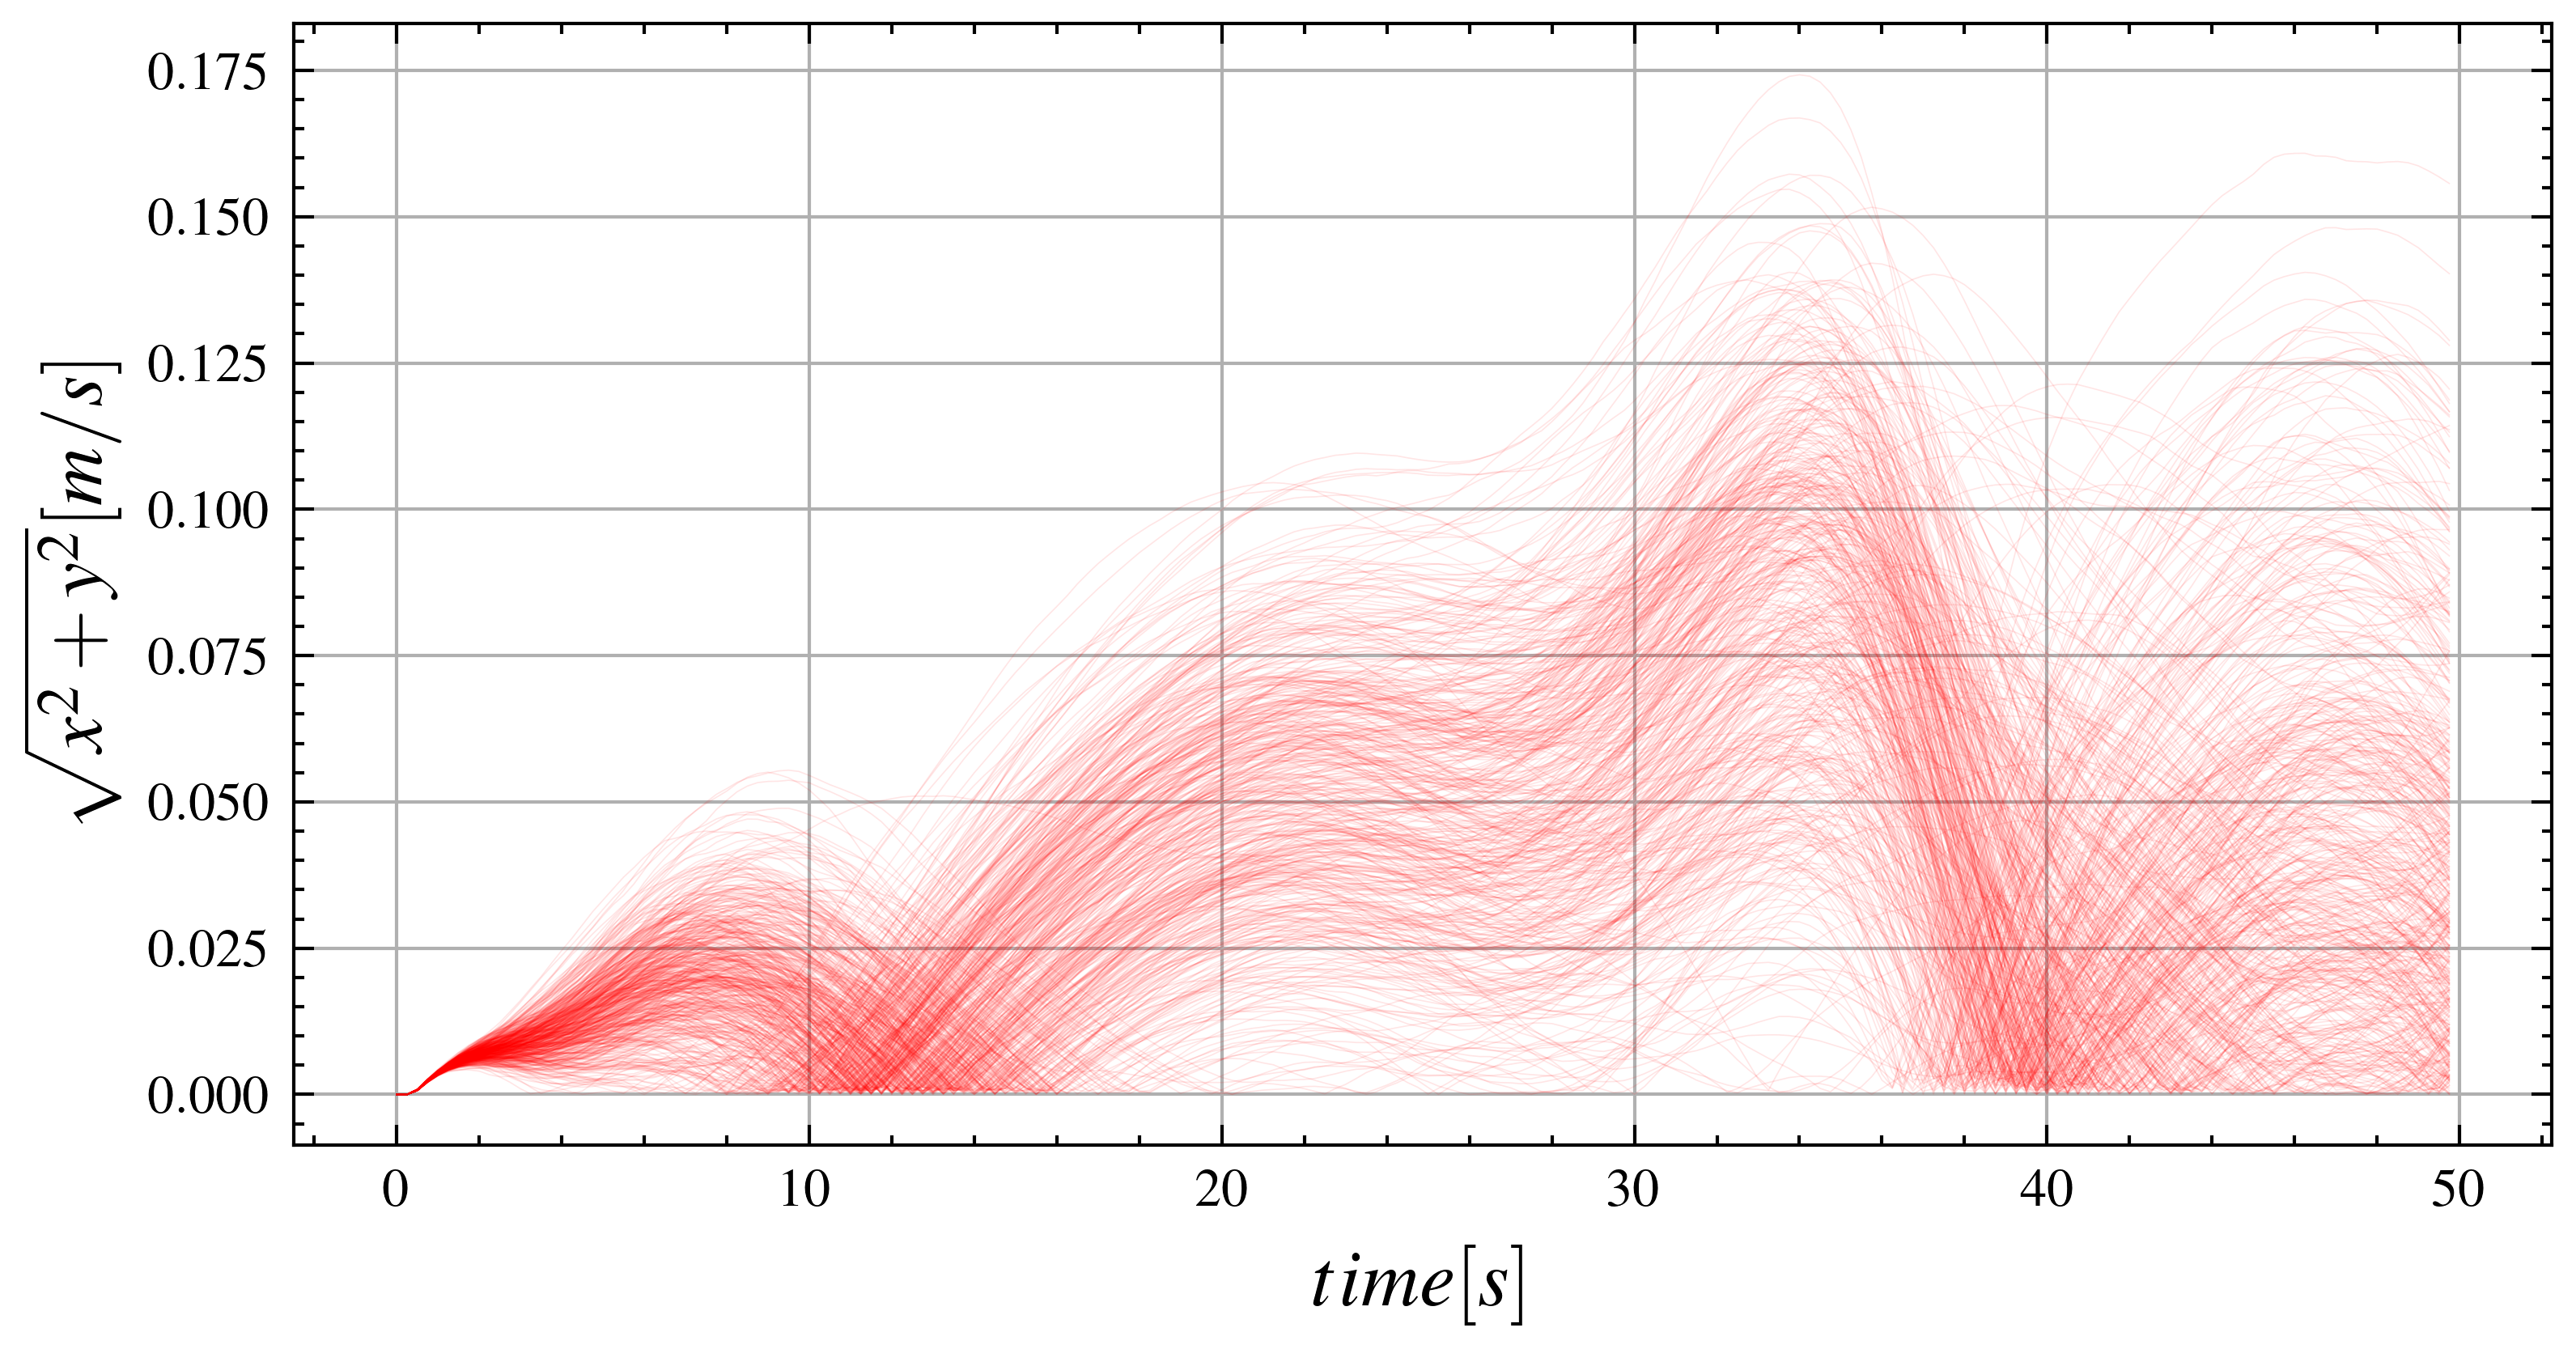

In [130]:
fig = plt.figure(figsize=(4.5, 3))
ax = fig.add_subplot(1, 1, 1)
for i in num1:num2
    ax.plot(results2.data2[i][1:sampling,"y"], results2.data2[i][1:sampling,"x"], "-", alpha=0.1,  c="r", linewidth=0.2)
end
ax.plot(obs[1:sampling,"y"], obs[1:sampling,"x"], "-", label="Target", c="k", alpha=0.8, linewidth=0.8)
ax.set_ylabel(L"x[m]", fontsize=12)
ax.set_xlabel(L"y[m]", fontsize=12)
ax.legend(frameon=true, loc="upper left", fontsize=9)
# ax.set_ylim(0, 10)
# ax.set_xlim(-3, 12)
# ax.set_ylim(-5, 13)
# ax.set_xlim(-7, 20)
ax.set_ylim(-0.5, 7.5)
ax.set_xlim(-2, 10)
ax.grid()
display(fig)

fig = plt.figure(figsize=(4,8))
ax = fig.add_subplot(3, 1, 1)
for i in num1:num2
    ax.plot(results2.data2[i][1:sampling,"time"], results2.data2[i][1:sampling,"u"], "-", c="r", alpha=0.1, linewidth=0.2)
end
ax.plot(obs[1:sampling,"time"], obs[1:sampling,"u"], "-", c="k", linewidth=1)
ax.set_ylabel(L"u[m/s]", fontsize=12)
ax.grid()
ax = fig.add_subplot(3, 1, 2)
for i in num1:num2
    ax.plot(results2.data2[i][1:sampling,"time"], results2.data2[i][1:sampling,"v"], "-", c="r", alpha=0.1, linewidth=0.2)
end
ax.plot(obs[1:sampling,"time"], obs[1:sampling,"v"], "-", c="k", linewidth=1)
ax.set_ylabel(L"v[m/s]", fontsize=12)
ax.grid()
ax = fig.add_subplot(3, 1, 3)
for i in num1:num2
    ax.plot(results2.data2[i][1:sampling,"time"], results2.data2[i][1:sampling,"r"], "-", c="r", alpha=0.1, linewidth=0.2)
end
ax.plot(obs[1:sampling,"time"], obs[1:sampling,"r"], "-", c="k", linewidth=1)
ax.set_ylabel(L"r[rad/s]", fontsize=12)
ax.set_xlabel(L"time[s]", fontsize=12)
ax.grid()
display(fig)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
for i in num1:num2
    ax.plot(results2.data2[i][1:sampling,"time"], sqrt.(results2.data2[i][1:sampling,"x"].^2 + results2.data2[i][1:sampling,"y"].^2), "-", c="r", alpha=0.1, linewidth=0.2)
end
ax.plot(obs[1:sampling,"time"], sqrt.(obs[1:sampling,"x"].^2 + obs[1:sampling,"y"].^2), "-", c="k", linewidth=1)
ax.set_ylabel(L"\sqrt{x^2+y^2}[m]", fontsize=12)
ax.set_xlabel(L"time[s]", fontsize=12)
ax.grid()
display(fig)

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(1, 1, 1)
for i in num1:num2
    ax.plot(results2.data2[i][1:sampling,"time"], abs.(sqrt.(results2.data2[i][1:sampling,"x"].^2 + results2.data2[i][1:sampling,"y"].^2)-sqrt.(obs[1:sampling,"x"].^2 + obs[1:sampling,"y"].^2)), "-", c="r", alpha=0.1, linewidth=0.2)
end
ax.set_ylabel(L"\sqrt{x^2+y^2}[m/s]", fontsize=12)
ax.set_xlabel(L"time[s]", fontsize=12)
ax.grid()
display(fig)